<a href="https://colab.research.google.com/github/cheneeheng/Transformer-TF/blob/colab_dev/Cifar10_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Classification**

Based on [CIFAR10_Keras_GPU.ipynb](https://github.com/katnoria/cifar10-native-vs-colab/blob/master/CIFAR10_Keras_GPU.ipynb) from [katnoria/cifar10-native-vs-colab](https://github.com/katnoria/cifar10-native-vs-colab) .

General info about the dataset:
- 50K Train, 10K Test
- 10 object classes


# Imports

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
tf.__version__

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'2.4.1'

# Data generator

In [2]:
from tensorflow.keras.datasets import cifar10

(x_trn_full, y_trn_full), (x_tst, y_tst) = cifar10.load_data()

# remove the last dimension
y_trn_full = y_trn_full.reshape(y_trn_full.shape[0],)
y_tst = y_tst.reshape(y_tst.shape[0],)

# perform in model.
# # normalize data to 0..1
# x_trn_full, x_tst = x_trn_full / 255.0, x_tst / 255.0

# create validation split
# split = 0.2
# x_trn, x_val, y_trn, y_val = train_test_split(
#     x_trn_full, y_trn_full, test_size=split, random_state=1969)
x_trn, x_val, y_trn, y_val = x_trn_full, x_tst, y_trn_full, y_tst

print(f'x_trn.shape: {x_trn.shape}')
print(f'y_trn.shape: {y_trn.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'x_tst shape: {x_tst.shape}')
print(f'y_tst.shape: {y_tst.shape}')

170500096/170498071 [==============================] - 2s 0us/step
x_trn.shape: (50000, 32, 32, 3)
y_trn.shape: (50000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)
x_tst shape: (10000, 32, 32, 3)
y_tst.shape: (10000,)


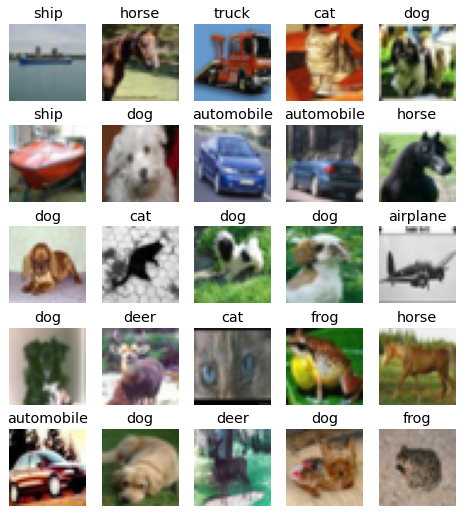

In [3]:
# pick 25 random images and plot
idxs = np.random.randint(x_trn.shape[0], size=25)
images = x_trn[idxs]
labels = y_trn[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

In [4]:
class Patches(tf.keras.layers.Layer):
  """Creates patches from an image. Implemented as a keras layer."""
  def __init__(self, patch_size: int):
    super().__init__()
    self.patch_size = patch_size

  def call(self, x):
    batch_size = tf.shape(x)[0]
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

  def get_config(self):
    return {"patch_size": self.patch_size}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


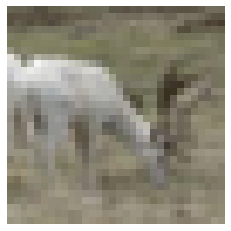

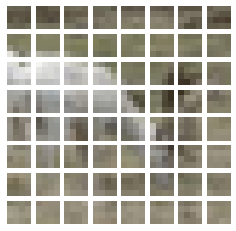

In [5]:
plt.figure(figsize=(4, 4))
image = x_trn[np.random.choice(range(x_trn.shape[0]))]
plt.imshow(image)
plt.axis("off")

image_size = 32
patch_size = 4

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [6]:
def data_generator(split: str, batch_size: int, shuffle_buffer: int = 10000):
  """Creates a tf.data.Dataset instance.

  Args:
      split: The type of data to generate, ['train', 'val', 'test'].
      batch_size: Batch size.
      shuffle_buffer: Number of elements used for shuffling.

  Returns:
      A tf.data.Dataset instance.

  Raises:
      ValueError: If `split` is not ['train', 'val', 'test'].

  """
  if split == 'train':
    ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
    ds = ds.shuffle(shuffle_buffer)
  elif split == 'val':
    ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  elif split == 'test':
    ds = tf.data.Dataset.from_tensor_slices((x_tst, y_tst))
  else:
    raise ValueError(f"Unknown data split : {split}")
  return ds.batch(batch_size)

# Model

A simple CNN example from the keras [CNN benchmark](https://github.com/keras-team/keras/blob/master/keras/benchmarks/keras_examples_benchmarks/cifar10_cnn_benchmark_test.py) .  
It is based on this [CNN example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) but the example is no longer available.


In [7]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Conv2D, 
  BatchNormalization, 
  MaxPool2D,
  Dropout,
  Flatten,
  Dense
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  RandomFlip,
  RandomTranslation,
  RandomRotation,
  RandomZoom,
  Normalization,
  Rescaling,
  Resizing
)

def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  
def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)

class SmallCNN(Model):
  """SmallCNN implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """

  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               preprocess: bool = False):
    super().__init__()

    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')
    self.conv3 = conv2d(64, 3, name='conv3', padding='same')
    self.conv4 = conv2d(64, 3, name='conv4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')
    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.dens6 = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)
    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)
    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)
    x = self.pool4(self.conv4(self.conv3(x)))
    x = self.drop4(x, training=training)
    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.dens6(x)
    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
    return {"num_classes": self.num_classes,
            "image_height": self.image_height,
            "image_width": self.image_width,
            "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
    return cls(**config)

[Vision Transformer](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al.  
Code taken from this [example](https://keras.io/examples/vision/image_classification_with_vision_transformer/) .

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Layer,
  Add,
  BatchNormalization, 
  Conv2D, 
  Dense,
  Dropout,
  Embedding,
  Flatten,
  LayerNormalization,
  MaxPool2D,
  MultiHeadAttention
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, gelu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)

def mlp(hidden_units: list, dropout_rate: float, name: str = ''):
  """Multilayer perceptron."""
  layers = []
  for idx, units in enumerate(hidden_units):
    layers.append(Dense(units, activation=gelu, name=f'{name}/dens{idx}'))
    layers.append(Dropout(dropout_rate, name=f'{name}/drop{idx}'))
  return layers

class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self, hidden_units: list, dropout_rate: float):
    super().__init__()
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate
    
    self.layers = []
    self.dropouts = []
    for idx, units in enumerate(self.hidden_units):
      self.layers.append(Dense(units, activation=gelu, name=f'dens{idx}'))
      self.dropouts.append(Dropout(dropout_rate))

  def call(self, x, training: bool = None):
    for layer_i, dropout_i in zip(self.layers, self.dropouts):
        x = layer_i(x)
        x = dropout_i(x, training=training)
    return x
  
  def get_config(self):
    return {"hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class PatchEncoder(Layer):
  """Encoder for the image patches."""
  def __init__(self, num_patches: int, projection_dim: int):
    super().__init__()
    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.projection = Dense(units=self.projection_dim)
    self.position_embedding = Embedding(input_dim=num_patches,
                                        output_dim=self.projection_dim)

  def call(self, x):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(x) + self.position_embedding(positions)
    return encoded
  
  def get_config(self):
    return {"num_patches": self.num_patches,
            "projection_dim": self.projection_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class VIT(Model):
  """Vision Transformer implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               patch_size: int, 
               projection_dim: int,
               num_layers: int,
               num_heads: int,
               mlp_dims: list,
               classifier_mlp_dims: list,
               preprocess: bool = False):
    super().__init__()
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.patch_size = patch_size
    self.projection_dim = projection_dim
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.mlp_dims = mlp_dims
    self.classifier_mlp_dims = classifier_mlp_dims
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Patches
    self.patch = Patches(self.patch_size)
    num_patches = (self.image_height // self.patch_size) * \
                  (self.image_width // self.patch_size)
    self.patch_enc = PatchEncoder(num_patches, self.projection_dim)

    # Model
    self.transformer_blocks = []
    for idx in range(self.num_layers):
      block = []
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_1')]
      block += [MultiHeadAttention(self.num_heads, 
                                   self.projection_dim, 
                                   dropout=0.1, 
                                   name=f'mha{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_1')]
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_2')]
      block += [mlp(mlp_dims, dropout_rate=0.1, name=f'mlp{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_2')]
      self.transformer_blocks.append(block)

    self.lnorm = LayerNormalization(epsilon=1e-6, name='classifier_ln')
    self.flat = Flatten(name='classifier_flat')
    self.drop = Dropout(0.5, name='classifier_drop')
    self.mlp = mlp(self.classifier_mlp_dims, dropout_rate=0.5, 
                   name='classifier_mlp')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.patch(x)
    x = self.patch_enc(x)
    
    for block in self.transformer_blocks:
      x_layer_norm_1 = block[0](x)
      x_attention    = block[1](x_layer_norm_1, x_layer_norm_1)
      x_skip         = block[2]([x_attention, x])
      x_layer_norm_2 = block[3](x_skip)
      x_mlp          = self._iterate_mlp(block[4], x_layer_norm_2)
      x              = block[5]([x_mlp, x_skip])
    
    x = self.lnorm(x)
    x = self.flat(x)
    x = self.drop(x, training=training)
    x = self._iterate_mlp(self.mlp, x)
    x = self.logits(x)
    return x
  
  @staticmethod
  def _iterate_mlp(mlp_layers: list, x: tf.Tensor):
    _x = x
    for mlp_i in mlp_layers:
      _x = mlp_i(_x)
    return _x

  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

Save an initial copy of the weights.  
The weights will be used to initialize all the experiments, allowing for fair comparison.


In [9]:
%%script false 
# Kept as reference.

# # Saves a full copy of the model.
# model_SmallCNN = SmallCNN(num_classes=10, 
#                           image_height=32, 
#                           image_width=32,
#                           preprocess=False).model()
# model_SmallCNN.save('model_SmallCNN')

# # Loads model
# model_SmallCNN = tf.keras.models.load_model('model_SmallCNN')
# model_SmallCNN.summary()

# # Saves a full copy of the model.
# model_VIT = VIT(num_classes=10, 
#                 image_height=32, 
#                 image_width=32,
#                 patch_size=4, 
#                 projection_dim=32,
#                 num_layers=4,
#                 num_heads=4,
#                 mlp_dims=[64, 32],
#                 classifier_mlp_dims=[512],
#                 preprocess=False).model()
# model_VIT.save('model_VIT')

# # Loads model
# model_VIT = tf.keras.models.load_model('model_VIT')
# model_VIT.summary()

# # Saves only the weights of the model.
# model = SmallCNN(num_classes=10)
# model(tf.zeros([1,32,32,3]))
# model.save_weights('model.h5')

# # Loads weights
# model.load_weights('model.h5')
# model.preprocess = True
# for layer in model.model().layers:
#   print(layer.output)
# model.model().summary()

# Train

Training configs.

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy
batch_size = 256
shuffle_buffer = 50000
epochs = 50
learning_rate = 1e-3

num_classes = 10 
image_height = 32
image_width = 32

Keras model.compile(...) and model.fit(...) .


In [12]:
def train_and_eval(_model, _checkpoint_filepath):
  """Wrapper code for training and evaluating.

  Args:
      _model: A keras Model.
      _checkpoint_filepath: Path to save a checkpoint.

  Returns:
      A history instance that contains logged values per epoch.

  """
  _model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_fn,
    metrics=[acc_metric_fn(name='sparse_categorical_accuracy')]
  )

  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    _checkpoint_filepath,
    monitor="val_sparse_categorical_accuracy",
    save_best_only=True,
  )

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join(_checkpoint_filepath, 'logs'), 
    histogram_freq=epochs//10,
    update_freq='epoch'
  )

  start = time()
  history = _model.fit(
      data_generator('train', batch_size, shuffle_buffer), 
      epochs=epochs, 
      steps_per_epoch=len(data_generator('train', batch_size, shuffle_buffer)),
      validation_data=data_generator('val', batch_size),
      callbacks=[tensorboard_callback, checkpoint_callback],
  )
  end = time()
  print(f'Total training time {end - start} seconds')
  
  return history

Native TF with GradientTape.  
This is exactly the same as using compite(...) and fit(...) in keras.  
However, this exposes the gradient and the train loop, allowing for more flexibility.

In [13]:
%%script false
# This is just for reference.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = acc_metric_fn(name='sparse_categorical_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = acc_metric_fn(name='val_sparse_categorical_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  # Container to keep the results.
  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def val_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  v_loss = loss_fn(labels, predictions)
  # Container to keep the results.
  val_loss(v_loss)
  val_accuracy(labels, predictions)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
progbar = tf.keras.utils.Progbar
trn_ds = data_generator('train', batch_size, shuffle_buffer)
val_ds = data_generator('val', batch_size)

start = time()
for epoch in range(epochs):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  print(f"Epoch {epoch+1}/{epochs}")
  pb_i = progbar(steps_per_epoch=len(trn_ds), 
                 stateful_metrics=['Loss', 'Accuracy',
                                   'Val Loss', 'Val Accuracy'])
  
  for idx, (images, labels) in enumerate(trn_ds):
    train_step(images, labels)
    if idx + 1 < mini_batches:
      pb_i.add(1, values=[('Loss', train_loss.result()), 
                          ('Accuracy', train_accuracy.result())])

  for val_images, val_labels in val_ds:
    val_step(val_images, val_labels)
  pb_i.add(1, values=[('Loss', train_loss.result()), 
                      ('Accuracy', train_accuracy.result()),
                      ('Val Loss', val_loss.result()), 
                      ('Val Accuracy', val_accuracy.result())])

  train_losses.append(train_loss.result())
  train_accuracies.append(train_accuracy.result())
  val_losses.append(val_loss.result())
  val_accuracies.append(val_accuracy.result())

end = time()

print(f'Total training time {end - start} seconds')

**Experiment 1**  
Model : CNN  
Preprocessing : False  
Batch size : 256

In [14]:
model = SmallCNN(num_classes=num_classes, 
                 image_height=image_height, 
                 image_width=image_width,
                 preprocess=False).model()
model.summary()
history_cnn = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0     

**Experiment 2**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4

In [15]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4 = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 2/50
196/196 [==============================] - 9s 45ms/step - loss: 1.8249 - sparse_categorical_accuracy: 0.3350 - val_loss: 1.4730 - val_sparse_categorical_accuracy: 0.4617


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 3/50
196/196 [==============================] - 9s 46ms/step - loss: 1.5925 - sparse_categorical_accuracy: 0.4223 - val_loss: 1.4027 - val_sparse_categorical_accuracy: 0.4909


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 4/50
196/196 [==============================] - 9s 46ms/step - loss: 1.5046 - sparse_categorical_accuracy: 0.4540 - val_loss: 1.3753 - val_sparse_categorical_accuracy: 0.4964


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 5/50
196/196 [==============================] - 9s 45ms/step - loss: 1.4262 - sparse_categorical_accuracy: 0.4808 - val_loss: 1.2746 - val_sparse_categorical_accuracy: 0.5333


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 6/50
196/196 [==============================] - 9s 46ms/step - loss: 1.3715 - sparse_categorical_accuracy: 0.5034 - val_loss: 1.2302 - val_sparse_categorical_accuracy: 0.5540


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 7/50
196/196 [==============================] - 9s 46ms/step - loss: 1.3264 - sparse_categorical_accuracy: 0.5227 - val_loss: 1.2190 - val_sparse_categorical_accuracy: 0.5648


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 8/50
196/196 [==============================] - 9s 46ms/step - loss: 1.2823 - sparse_categorical_accuracy: 0.5356 - val_loss: 1.1637 - val_sparse_categorical_accuracy: 0.5813


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 9/50
196/196 [==============================] - 9s 46ms/step - loss: 1.2500 - sparse_categorical_accuracy: 0.5510 - val_loss: 1.1439 - val_sparse_categorical_accuracy: 0.5844


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 10/50
196/196 [==============================] - 9s 46ms/step - loss: 1.2111 - sparse_categorical_accuracy: 0.5659 - val_loss: 1.1185 - val_sparse_categorical_accuracy: 0.5967


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 11/50
196/196 [==============================] - 9s 46ms/step - loss: 1.1905 - sparse_categorical_accuracy: 0.5737 - val_loss: 1.0987 - val_sparse_categorical_accuracy: 0.6002


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 12/50
196/196 [==============================] - 9s 46ms/step - loss: 1.1497 - sparse_categorical_accuracy: 0.5898 - val_loss: 1.0811 - val_sparse_categorical_accuracy: 0.6099


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 13/50
196/196 [==============================] - 9s 46ms/step - loss: 1.1131 - sparse_categorical_accuracy: 0.6046 - val_loss: 1.0720 - val_sparse_categorical_accuracy: 0.6128


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 14/50
196/196 [==============================] - 9s 46ms/step - loss: 1.0931 - sparse_categorical_accuracy: 0.6097 - val_loss: 1.0414 - val_sparse_categorical_accuracy: 0.6268


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 15/50
196/196 [==============================] - 9s 46ms/step - loss: 1.0783 - sparse_categorical_accuracy: 0.6118 - val_loss: 1.0350 - val_sparse_categorical_accuracy: 0.6263
Epoch 16/50
196/196 [==============================] - 9s 46ms/step - loss: 1.0519 - sparse_categorical_accuracy: 0.6241 - val_loss: 1.0006 - val_sparse_categorical_accuracy: 0.6416


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 17/50
196/196 [==============================] - 9s 45ms/step - loss: 1.0282 - sparse_categorical_accuracy: 0.6354 - val_loss: 0.9904 - val_sparse_categorical_accuracy: 0.6421


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 18/50
196/196 [==============================] - 9s 45ms/step - loss: 1.0113 - sparse_categorical_accuracy: 0.6402 - val_loss: 0.9939 - val_sparse_categorical_accuracy: 0.6417
Epoch 19/50
196/196 [==============================] - 9s 46ms/step - loss: 0.9952 - sparse_categorical_accuracy: 0.6460 - val_loss: 0.9722 - val_sparse_categorical_accuracy: 0.6498


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 20/50
196/196 [==============================] - 9s 45ms/step - loss: 0.9742 - sparse_categorical_accuracy: 0.6535 - val_loss: 0.9936 - val_sparse_categorical_accuracy: 0.6485
Epoch 21/50
196/196 [==============================] - 9s 45ms/step - loss: 0.9662 - sparse_categorical_accuracy: 0.6598 - val_loss: 0.9787 - val_sparse_categorical_accuracy: 0.6458
Epoch 22/50
196/196 [==============================] - 9s 45ms/step - loss: 0.9437 - sparse_categorical_accuracy: 0.6628 - val_loss: 0.9550 - val_sparse_categorical_accuracy: 0.6597


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 23/50
196/196 [==============================] - 9s 45ms/step - loss: 0.9142 - sparse_categorical_accuracy: 0.6735 - val_loss: 0.9429 - val_sparse_categorical_accuracy: 0.6660


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 24/50
196/196 [==============================] - 9s 45ms/step - loss: 0.8995 - sparse_categorical_accuracy: 0.6825 - val_loss: 0.9335 - val_sparse_categorical_accuracy: 0.6686


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 25/50
196/196 [==============================] - 9s 46ms/step - loss: 0.8864 - sparse_categorical_accuracy: 0.6850 - val_loss: 0.9251 - val_sparse_categorical_accuracy: 0.6715


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 26/50
196/196 [==============================] - 9s 46ms/step - loss: 0.8694 - sparse_categorical_accuracy: 0.6889 - val_loss: 0.9432 - val_sparse_categorical_accuracy: 0.6643
Epoch 27/50
196/196 [==============================] - 9s 46ms/step - loss: 0.8532 - sparse_categorical_accuracy: 0.6978 - val_loss: 0.9103 - val_sparse_categorical_accuracy: 0.6784


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 28/50
196/196 [==============================] - 9s 45ms/step - loss: 0.8471 - sparse_categorical_accuracy: 0.6983 - val_loss: 0.9029 - val_sparse_categorical_accuracy: 0.6799


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 29/50
196/196 [==============================] - 9s 45ms/step - loss: 0.8176 - sparse_categorical_accuracy: 0.7072 - val_loss: 0.9095 - val_sparse_categorical_accuracy: 0.6786
Epoch 30/50
196/196 [==============================] - 9s 45ms/step - loss: 0.8101 - sparse_categorical_accuracy: 0.7112 - val_loss: 0.8929 - val_sparse_categorical_accuracy: 0.6845


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 31/50
196/196 [==============================] - 9s 46ms/step - loss: 0.7964 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.8794 - val_sparse_categorical_accuracy: 0.6928


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 32/50
196/196 [==============================] - 9s 45ms/step - loss: 0.7656 - sparse_categorical_accuracy: 0.7297 - val_loss: 0.8939 - val_sparse_categorical_accuracy: 0.6873
Epoch 33/50
196/196 [==============================] - 9s 46ms/step - loss: 0.7781 - sparse_categorical_accuracy: 0.7249 - val_loss: 0.8843 - val_sparse_categorical_accuracy: 0.6883
Epoch 34/50
196/196 [==============================] - 9s 46ms/step - loss: 0.7628 - sparse_categorical_accuracy: 0.7266 - val_loss: 0.8682 - val_sparse_categorical_accuracy: 0.6949


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 35/50
196/196 [==============================] - 9s 46ms/step - loss: 0.7468 - sparse_categorical_accuracy: 0.7332 - val_loss: 0.8583 - val_sparse_categorical_accuracy: 0.7005


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 36/50
196/196 [==============================] - 9s 45ms/step - loss: 0.7380 - sparse_categorical_accuracy: 0.7354 - val_loss: 0.8704 - val_sparse_categorical_accuracy: 0.6953
Epoch 37/50
196/196 [==============================] - 9s 45ms/step - loss: 0.7220 - sparse_categorical_accuracy: 0.7446 - val_loss: 0.8568 - val_sparse_categorical_accuracy: 0.6954
Epoch 38/50
196/196 [==============================] - 9s 45ms/step - loss: 0.7182 - sparse_categorical_accuracy: 0.7487 - val_loss: 0.8745 - val_sparse_categorical_accuracy: 0.6978
Epoch 39/50
196/196 [==============================] - 9s 46ms/step - loss: 0.7069 - sparse_categorical_accuracy: 0.7479 - val_loss: 0.8511 - val_sparse_categorical_accuracy: 0.6997
Epoch 40/50
196/196 [==============================] - 9s 45ms/step - loss: 0.6902 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.8447 - val_sparse_categorical_accuracy: 0.7049


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 41/50
196/196 [==============================] - 9s 46ms/step - loss: 0.6855 - sparse_categorical_accuracy: 0.7565 - val_loss: 0.8506 - val_sparse_categorical_accuracy: 0.7065


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 42/50
196/196 [==============================] - 9s 46ms/step - loss: 0.6806 - sparse_categorical_accuracy: 0.7591 - val_loss: 0.8631 - val_sparse_categorical_accuracy: 0.7027
Epoch 43/50
196/196 [==============================] - 9s 46ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.7640 - val_loss: 0.8574 - val_sparse_categorical_accuracy: 0.7017
Epoch 44/50
196/196 [==============================] - 9s 46ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.7675 - val_loss: 0.8439 - val_sparse_categorical_accuracy: 0.7086


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 45/50
196/196 [==============================] - 9s 46ms/step - loss: 0.6469 - sparse_categorical_accuracy: 0.7724 - val_loss: 0.8544 - val_sparse_categorical_accuracy: 0.6978
Epoch 46/50
196/196 [==============================] - 9s 45ms/step - loss: 0.6403 - sparse_categorical_accuracy: 0.7729 - val_loss: 0.8461 - val_sparse_categorical_accuracy: 0.7128


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 47/50
196/196 [==============================] - 9s 46ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.7753 - val_loss: 0.8212 - val_sparse_categorical_accuracy: 0.7134


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 48/50
196/196 [==============================] - 9s 46ms/step - loss: 0.6220 - sparse_categorical_accuracy: 0.7788 - val_loss: 0.8340 - val_sparse_categorical_accuracy: 0.7131
Epoch 49/50
196/196 [==============================] - 9s 45ms/step - loss: 0.6096 - sparse_categorical_accuracy: 0.7834 - val_loss: 0.8289 - val_sparse_categorical_accuracy: 0.7118
Epoch 50/50
196/196 [==============================] - 9s 46ms/step - loss: 0.6116 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.8263 - val_sparse_categorical_accuracy: 0.7134
Total training time 676.0488376617432 seconds


**Experiment 3**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 16x16

In [16]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=16, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_16x16 = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_2 (Patches)             (None, None, 768)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 2/50
196/196 [==============================] - 4s 19ms/step - loss: 1.8735 - sparse_categorical_accuracy: 0.3228 - val_loss: 1.6637 - val_sparse_categorical_accuracy: 0.3985


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 3/50
196/196 [==============================] - 4s 19ms/step - loss: 1.7590 - sparse_categorical_accuracy: 0.3582 - val_loss: 1.5687 - val_sparse_categorical_accuracy: 0.4341


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 4/50
196/196 [==============================] - 4s 18ms/step - loss: 1.6770 - sparse_categorical_accuracy: 0.3900 - val_loss: 1.5524 - val_sparse_categorical_accuracy: 0.4364


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 5/50
196/196 [==============================] - 4s 18ms/step - loss: 1.6356 - sparse_categorical_accuracy: 0.4103 - val_loss: 1.5027 - val_sparse_categorical_accuracy: 0.4582


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 6/50
196/196 [==============================] - 4s 20ms/step - loss: 1.6087 - sparse_categorical_accuracy: 0.4175 - val_loss: 1.4547 - val_sparse_categorical_accuracy: 0.4758


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 7/50
196/196 [==============================] - 4s 19ms/step - loss: 1.5570 - sparse_categorical_accuracy: 0.4340 - val_loss: 1.4399 - val_sparse_categorical_accuracy: 0.4814


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 8/50
196/196 [==============================] - 4s 17ms/step - loss: 1.5308 - sparse_categorical_accuracy: 0.4491 - val_loss: 1.4113 - val_sparse_categorical_accuracy: 0.4937


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 9/50
196/196 [==============================] - 3s 17ms/step - loss: 1.5080 - sparse_categorical_accuracy: 0.4534 - val_loss: 1.4097 - val_sparse_categorical_accuracy: 0.4912
Epoch 10/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4957 - sparse_categorical_accuracy: 0.4628 - val_loss: 1.4011 - val_sparse_categorical_accuracy: 0.4979


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 11/50
196/196 [==============================] - 4s 21ms/step - loss: 1.4768 - sparse_categorical_accuracy: 0.4652 - val_loss: 1.3899 - val_sparse_categorical_accuracy: 0.5011


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 12/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4522 - sparse_categorical_accuracy: 0.4809 - val_loss: 1.3730 - val_sparse_categorical_accuracy: 0.5058


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 13/50
196/196 [==============================] - 4s 18ms/step - loss: 1.4402 - sparse_categorical_accuracy: 0.4813 - val_loss: 1.3656 - val_sparse_categorical_accuracy: 0.5087


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 14/50
196/196 [==============================] - 4s 19ms/step - loss: 1.4299 - sparse_categorical_accuracy: 0.4881 - val_loss: 1.3578 - val_sparse_categorical_accuracy: 0.5106


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 15/50
196/196 [==============================] - 4s 18ms/step - loss: 1.4117 - sparse_categorical_accuracy: 0.4950 - val_loss: 1.3484 - val_sparse_categorical_accuracy: 0.5154


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 16/50
196/196 [==============================] - 4s 21ms/step - loss: 1.3982 - sparse_categorical_accuracy: 0.4972 - val_loss: 1.3410 - val_sparse_categorical_accuracy: 0.5127
Epoch 17/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3901 - sparse_categorical_accuracy: 0.4991 - val_loss: 1.3318 - val_sparse_categorical_accuracy: 0.5232


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 18/50
196/196 [==============================] - 4s 22ms/step - loss: 1.3769 - sparse_categorical_accuracy: 0.5083 - val_loss: 1.3213 - val_sparse_categorical_accuracy: 0.5237


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 19/50
196/196 [==============================] - 4s 20ms/step - loss: 1.3653 - sparse_categorical_accuracy: 0.5115 - val_loss: 1.3173 - val_sparse_categorical_accuracy: 0.5235
Epoch 20/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3517 - sparse_categorical_accuracy: 0.5173 - val_loss: 1.3239 - val_sparse_categorical_accuracy: 0.5199
Epoch 21/50
196/196 [==============================] - 4s 21ms/step - loss: 1.3355 - sparse_categorical_accuracy: 0.5193 - val_loss: 1.3199 - val_sparse_categorical_accuracy: 0.5244


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 22/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3420 - sparse_categorical_accuracy: 0.5197 - val_loss: 1.3128 - val_sparse_categorical_accuracy: 0.5292


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 23/50
196/196 [==============================] - 4s 21ms/step - loss: 1.3252 - sparse_categorical_accuracy: 0.5283 - val_loss: 1.3099 - val_sparse_categorical_accuracy: 0.5336


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 24/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3135 - sparse_categorical_accuracy: 0.5303 - val_loss: 1.3001 - val_sparse_categorical_accuracy: 0.5330
Epoch 25/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3100 - sparse_categorical_accuracy: 0.5286 - val_loss: 1.3088 - val_sparse_categorical_accuracy: 0.5286
Epoch 26/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2911 - sparse_categorical_accuracy: 0.5368 - val_loss: 1.3094 - val_sparse_categorical_accuracy: 0.5285
Epoch 27/50
196/196 [==============================] - 4s 21ms/step - loss: 1.2841 - sparse_categorical_accuracy: 0.5389 - val_loss: 1.3015 - val_sparse_categorical_accuracy: 0.5338


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 28/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2774 - sparse_categorical_accuracy: 0.5436 - val_loss: 1.2966 - val_sparse_categorical_accuracy: 0.5349


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 29/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2664 - sparse_categorical_accuracy: 0.5450 - val_loss: 1.3209 - val_sparse_categorical_accuracy: 0.5251
Epoch 30/50
196/196 [==============================] - 4s 18ms/step - loss: 1.2686 - sparse_categorical_accuracy: 0.5440 - val_loss: 1.2882 - val_sparse_categorical_accuracy: 0.5382


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 31/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2570 - sparse_categorical_accuracy: 0.5472 - val_loss: 1.3058 - val_sparse_categorical_accuracy: 0.5342
Epoch 32/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2376 - sparse_categorical_accuracy: 0.5552 - val_loss: 1.2800 - val_sparse_categorical_accuracy: 0.5432


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 33/50
196/196 [==============================] - 3s 17ms/step - loss: 1.2477 - sparse_categorical_accuracy: 0.5572 - val_loss: 1.2959 - val_sparse_categorical_accuracy: 0.5348
Epoch 34/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2275 - sparse_categorical_accuracy: 0.5609 - val_loss: 1.2939 - val_sparse_categorical_accuracy: 0.5375
Epoch 35/50
196/196 [==============================] - 4s 18ms/step - loss: 1.2204 - sparse_categorical_accuracy: 0.5638 - val_loss: 1.2793 - val_sparse_categorical_accuracy: 0.5431
Epoch 36/50
196/196 [==============================] - 4s 18ms/step - loss: 1.2142 - sparse_categorical_accuracy: 0.5674 - val_loss: 1.2872 - val_sparse_categorical_accuracy: 0.5374
Epoch 37/50
196/196 [==============================] - 4s 18ms/step - loss: 1.2191 - sparse_categorical_accuracy: 0.5623 - val_loss: 1.2979 - val_sparse_categorical_accuracy: 0.5337
Epoch 38/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2075 - spars

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Total training time 359.8078293800354 seconds


**Experiment 4**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 8x8

In [17]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_8x8 = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_3 (Patches)             (None, None, 192)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 2/50
196/196 [==============================] - 4s 21ms/step - loss: 1.7964 - sparse_categorical_accuracy: 0.3405 - val_loss: 1.5334 - val_sparse_categorical_accuracy: 0.4490


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 3/50
196/196 [==============================] - 4s 22ms/step - loss: 1.6505 - sparse_categorical_accuracy: 0.4046 - val_loss: 1.4517 - val_sparse_categorical_accuracy: 0.4775


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 4/50
196/196 [==============================] - 4s 21ms/step - loss: 1.5551 - sparse_categorical_accuracy: 0.4357 - val_loss: 1.4115 - val_sparse_categorical_accuracy: 0.4901


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 5/50
196/196 [==============================] - 4s 20ms/step - loss: 1.5051 - sparse_categorical_accuracy: 0.4543 - val_loss: 1.3347 - val_sparse_categorical_accuracy: 0.5190


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 6/50
196/196 [==============================] - 4s 21ms/step - loss: 1.4327 - sparse_categorical_accuracy: 0.4813 - val_loss: 1.3053 - val_sparse_categorical_accuracy: 0.5307


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 7/50
196/196 [==============================] - 4s 21ms/step - loss: 1.4069 - sparse_categorical_accuracy: 0.4964 - val_loss: 1.2714 - val_sparse_categorical_accuracy: 0.5419


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 8/50
196/196 [==============================] - 4s 22ms/step - loss: 1.3536 - sparse_categorical_accuracy: 0.5126 - val_loss: 1.2538 - val_sparse_categorical_accuracy: 0.5457


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 9/50
196/196 [==============================] - 4s 20ms/step - loss: 1.3351 - sparse_categorical_accuracy: 0.5193 - val_loss: 1.2293 - val_sparse_categorical_accuracy: 0.5572


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 10/50
196/196 [==============================] - 4s 21ms/step - loss: 1.3041 - sparse_categorical_accuracy: 0.5283 - val_loss: 1.2020 - val_sparse_categorical_accuracy: 0.5686


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 11/50
196/196 [==============================] - 4s 22ms/step - loss: 1.2801 - sparse_categorical_accuracy: 0.5413 - val_loss: 1.2176 - val_sparse_categorical_accuracy: 0.5673
Epoch 12/50
196/196 [==============================] - 4s 21ms/step - loss: 1.2653 - sparse_categorical_accuracy: 0.5479 - val_loss: 1.1740 - val_sparse_categorical_accuracy: 0.5819


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 13/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2297 - sparse_categorical_accuracy: 0.5589 - val_loss: 1.1467 - val_sparse_categorical_accuracy: 0.5896


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 14/50
196/196 [==============================] - 4s 21ms/step - loss: 1.2147 - sparse_categorical_accuracy: 0.5634 - val_loss: 1.1542 - val_sparse_categorical_accuracy: 0.5868
Epoch 15/50
196/196 [==============================] - 4s 21ms/step - loss: 1.1955 - sparse_categorical_accuracy: 0.5726 - val_loss: 1.1430 - val_sparse_categorical_accuracy: 0.5933


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 16/50
196/196 [==============================] - 4s 22ms/step - loss: 1.1767 - sparse_categorical_accuracy: 0.5777 - val_loss: 1.1409 - val_sparse_categorical_accuracy: 0.5922
Epoch 17/50
196/196 [==============================] - 5s 23ms/step - loss: 1.1707 - sparse_categorical_accuracy: 0.5780 - val_loss: 1.1277 - val_sparse_categorical_accuracy: 0.5915
Epoch 18/50
196/196 [==============================] - 4s 22ms/step - loss: 1.1497 - sparse_categorical_accuracy: 0.5868 - val_loss: 1.1176 - val_sparse_categorical_accuracy: 0.6034


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 19/50
196/196 [==============================] - 4s 21ms/step - loss: 1.1288 - sparse_categorical_accuracy: 0.5947 - val_loss: 1.1120 - val_sparse_categorical_accuracy: 0.6046


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 20/50
196/196 [==============================] - 4s 22ms/step - loss: 1.1207 - sparse_categorical_accuracy: 0.5960 - val_loss: 1.0951 - val_sparse_categorical_accuracy: 0.6044
Epoch 21/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1198 - sparse_categorical_accuracy: 0.6020 - val_loss: 1.0944 - val_sparse_categorical_accuracy: 0.6074


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 22/50
196/196 [==============================] - 4s 22ms/step - loss: 1.1010 - sparse_categorical_accuracy: 0.6041 - val_loss: 1.0872 - val_sparse_categorical_accuracy: 0.6093


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 23/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0835 - sparse_categorical_accuracy: 0.6138 - val_loss: 1.0684 - val_sparse_categorical_accuracy: 0.6188


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 24/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0856 - sparse_categorical_accuracy: 0.6108 - val_loss: 1.0628 - val_sparse_categorical_accuracy: 0.6197


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 25/50
196/196 [==============================] - 4s 22ms/step - loss: 1.0595 - sparse_categorical_accuracy: 0.6215 - val_loss: 1.0695 - val_sparse_categorical_accuracy: 0.6174
Epoch 26/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0467 - sparse_categorical_accuracy: 0.6251 - val_loss: 1.0476 - val_sparse_categorical_accuracy: 0.6237


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 27/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0402 - sparse_categorical_accuracy: 0.6291 - val_loss: 1.0389 - val_sparse_categorical_accuracy: 0.6264


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 28/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0348 - sparse_categorical_accuracy: 0.6335 - val_loss: 1.0346 - val_sparse_categorical_accuracy: 0.6295


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 29/50
196/196 [==============================] - 4s 21ms/step - loss: 1.0193 - sparse_categorical_accuracy: 0.6340 - val_loss: 1.0556 - val_sparse_categorical_accuracy: 0.6221
Epoch 30/50
196/196 [==============================] - 4s 22ms/step - loss: 1.0141 - sparse_categorical_accuracy: 0.6346 - val_loss: 1.0308 - val_sparse_categorical_accuracy: 0.6329


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 31/50
196/196 [==============================] - 5s 23ms/step - loss: 1.0004 - sparse_categorical_accuracy: 0.6445 - val_loss: 1.0406 - val_sparse_categorical_accuracy: 0.6269
Epoch 32/50
196/196 [==============================] - 4s 21ms/step - loss: 0.9882 - sparse_categorical_accuracy: 0.6453 - val_loss: 1.0205 - val_sparse_categorical_accuracy: 0.6330


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 33/50
196/196 [==============================] - 4s 22ms/step - loss: 0.9819 - sparse_categorical_accuracy: 0.6485 - val_loss: 1.0606 - val_sparse_categorical_accuracy: 0.6238
Epoch 34/50
196/196 [==============================] - 4s 21ms/step - loss: 0.9816 - sparse_categorical_accuracy: 0.6515 - val_loss: 1.0062 - val_sparse_categorical_accuracy: 0.6426


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 35/50
196/196 [==============================] - 4s 23ms/step - loss: 0.9772 - sparse_categorical_accuracy: 0.6495 - val_loss: 1.0165 - val_sparse_categorical_accuracy: 0.6333
Epoch 36/50
196/196 [==============================] - 4s 21ms/step - loss: 0.9500 - sparse_categorical_accuracy: 0.6581 - val_loss: 1.0179 - val_sparse_categorical_accuracy: 0.6393
Epoch 37/50
196/196 [==============================] - 4s 22ms/step - loss: 0.9511 - sparse_categorical_accuracy: 0.6619 - val_loss: 0.9933 - val_sparse_categorical_accuracy: 0.6474


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 38/50
196/196 [==============================] - 4s 22ms/step - loss: 0.9482 - sparse_categorical_accuracy: 0.6611 - val_loss: 0.9954 - val_sparse_categorical_accuracy: 0.6449
Epoch 39/50
196/196 [==============================] - 4s 21ms/step - loss: 0.9298 - sparse_categorical_accuracy: 0.6691 - val_loss: 1.0096 - val_sparse_categorical_accuracy: 0.6368
Epoch 40/50
196/196 [==============================] - 4s 21ms/step - loss: 0.9358 - sparse_categorical_accuracy: 0.6645 - val_loss: 1.0011 - val_sparse_categorical_accuracy: 0.6465
Epoch 41/50
196/196 [==============================] - 4s 20ms/step - loss: 0.9230 - sparse_categorical_accuracy: 0.6675 - val_loss: 0.9922 - val_sparse_categorical_accuracy: 0.6522


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 42/50
196/196 [==============================] - 4s 22ms/step - loss: 0.9257 - sparse_categorical_accuracy: 0.6705 - val_loss: 0.9852 - val_sparse_categorical_accuracy: 0.6552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 43/50
196/196 [==============================] - 4s 21ms/step - loss: 0.9126 - sparse_categorical_accuracy: 0.6703 - val_loss: 0.9894 - val_sparse_categorical_accuracy: 0.6475
Epoch 44/50
196/196 [==============================] - 4s 21ms/step - loss: 0.8991 - sparse_categorical_accuracy: 0.6741 - val_loss: 0.9763 - val_sparse_categorical_accuracy: 0.6553


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 45/50
196/196 [==============================] - 4s 21ms/step - loss: 0.9016 - sparse_categorical_accuracy: 0.6770 - val_loss: 0.9800 - val_sparse_categorical_accuracy: 0.6539
Epoch 46/50
196/196 [==============================] - 4s 21ms/step - loss: 0.8968 - sparse_categorical_accuracy: 0.6806 - val_loss: 0.9835 - val_sparse_categorical_accuracy: 0.6511
Epoch 47/50
196/196 [==============================] - 4s 20ms/step - loss: 0.8817 - sparse_categorical_accuracy: 0.6843 - val_loss: 0.9922 - val_sparse_categorical_accuracy: 0.6500
Epoch 48/50
196/196 [==============================] - 4s 21ms/step - loss: 0.8939 - sparse_categorical_accuracy: 0.6790 - val_loss: 0.9842 - val_sparse_categorical_accuracy: 0.6572


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 49/50
196/196 [==============================] - 4s 20ms/step - loss: 0.8740 - sparse_categorical_accuracy: 0.6908 - val_loss: 0.9721 - val_sparse_categorical_accuracy: 0.6572
Epoch 50/50
196/196 [==============================] - 4s 20ms/step - loss: 0.8744 - sparse_categorical_accuracy: 0.6862 - val_loss: 0.9802 - val_sparse_categorical_accuracy: 0.6542
Total training time 424.1300268173218 seconds


**Experiment 5**  
Model : VIT  
Preprocessing : True  
Batch size : 256  
Patch : 8x8

In [18]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=True).model()
model.summary()
history_vit_8x8_pre = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
data_aug_flip (RandomFlip)      (None, 32, 32, 3)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 2/50
196/196 [==============================] - 4s 22ms/step - loss: 1.8314 - sparse_categorical_accuracy: 0.3374 - val_loss: 1.5597 - val_sparse_categorical_accuracy: 0.4411


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 3/50
196/196 [==============================] - 4s 21ms/step - loss: 1.6726 - sparse_categorical_accuracy: 0.3901 - val_loss: 1.4683 - val_sparse_categorical_accuracy: 0.4717


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 4/50
196/196 [==============================] - 5s 24ms/step - loss: 1.5937 - sparse_categorical_accuracy: 0.4223 - val_loss: 1.4121 - val_sparse_categorical_accuracy: 0.4923


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 5/50
196/196 [==============================] - 4s 22ms/step - loss: 1.5451 - sparse_categorical_accuracy: 0.4423 - val_loss: 1.4123 - val_sparse_categorical_accuracy: 0.4908
Epoch 6/50
196/196 [==============================] - 4s 22ms/step - loss: 1.4968 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.3545 - val_sparse_categorical_accuracy: 0.5108


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 7/50
196/196 [==============================] - 4s 22ms/step - loss: 1.4761 - sparse_categorical_accuracy: 0.4698 - val_loss: 1.3275 - val_sparse_categorical_accuracy: 0.5201


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 8/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4372 - sparse_categorical_accuracy: 0.4847 - val_loss: 1.2762 - val_sparse_categorical_accuracy: 0.5369


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 9/50
196/196 [==============================] - 5s 23ms/step - loss: 1.4086 - sparse_categorical_accuracy: 0.4941 - val_loss: 1.2618 - val_sparse_categorical_accuracy: 0.5415


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 10/50
196/196 [==============================] - 4s 22ms/step - loss: 1.3920 - sparse_categorical_accuracy: 0.5028 - val_loss: 1.2542 - val_sparse_categorical_accuracy: 0.5469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 11/50
196/196 [==============================] - 5s 23ms/step - loss: 1.3692 - sparse_categorical_accuracy: 0.5098 - val_loss: 1.2221 - val_sparse_categorical_accuracy: 0.5608


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 12/50
196/196 [==============================] - 5s 23ms/step - loss: 1.3467 - sparse_categorical_accuracy: 0.5215 - val_loss: 1.2069 - val_sparse_categorical_accuracy: 0.5667


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 13/50
196/196 [==============================] - 4s 22ms/step - loss: 1.3464 - sparse_categorical_accuracy: 0.5190 - val_loss: 1.2146 - val_sparse_categorical_accuracy: 0.5632
Epoch 14/50
196/196 [==============================] - 4s 21ms/step - loss: 1.3228 - sparse_categorical_accuracy: 0.5259 - val_loss: 1.2281 - val_sparse_categorical_accuracy: 0.5514
Epoch 15/50
196/196 [==============================] - 4s 22ms/step - loss: 1.3090 - sparse_categorical_accuracy: 0.5328 - val_loss: 1.1796 - val_sparse_categorical_accuracy: 0.5705


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 16/50
196/196 [==============================] - 5s 23ms/step - loss: 1.2881 - sparse_categorical_accuracy: 0.5407 - val_loss: 1.1844 - val_sparse_categorical_accuracy: 0.5791


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 17/50
196/196 [==============================] - 4s 22ms/step - loss: 1.2944 - sparse_categorical_accuracy: 0.5389 - val_loss: 1.1661 - val_sparse_categorical_accuracy: 0.5787
Epoch 18/50
196/196 [==============================] - 4s 22ms/step - loss: 1.2785 - sparse_categorical_accuracy: 0.5428 - val_loss: 1.1528 - val_sparse_categorical_accuracy: 0.5831


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 19/50
196/196 [==============================] - 4s 21ms/step - loss: 1.2595 - sparse_categorical_accuracy: 0.5487 - val_loss: 1.1481 - val_sparse_categorical_accuracy: 0.5893


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 20/50
196/196 [==============================] - 4s 22ms/step - loss: 1.2477 - sparse_categorical_accuracy: 0.5549 - val_loss: 1.1504 - val_sparse_categorical_accuracy: 0.5843
Epoch 21/50
196/196 [==============================] - 4s 22ms/step - loss: 1.2538 - sparse_categorical_accuracy: 0.5537 - val_loss: 1.1322 - val_sparse_categorical_accuracy: 0.5921


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 22/50
196/196 [==============================] - 5s 23ms/step - loss: 1.2391 - sparse_categorical_accuracy: 0.5596 - val_loss: 1.1504 - val_sparse_categorical_accuracy: 0.5833
Epoch 23/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2306 - sparse_categorical_accuracy: 0.5584 - val_loss: 1.1178 - val_sparse_categorical_accuracy: 0.5956


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 24/50
196/196 [==============================] - 4s 22ms/step - loss: 1.2149 - sparse_categorical_accuracy: 0.5620 - val_loss: 1.1052 - val_sparse_categorical_accuracy: 0.6019


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 25/50
196/196 [==============================] - 4s 22ms/step - loss: 1.2089 - sparse_categorical_accuracy: 0.5681 - val_loss: 1.0973 - val_sparse_categorical_accuracy: 0.6055


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 26/50
196/196 [==============================] - 5s 23ms/step - loss: 1.2032 - sparse_categorical_accuracy: 0.5728 - val_loss: 1.0985 - val_sparse_categorical_accuracy: 0.6032
Epoch 27/50
196/196 [==============================] - 4s 20ms/step - loss: 1.1859 - sparse_categorical_accuracy: 0.5792 - val_loss: 1.1086 - val_sparse_categorical_accuracy: 0.6005
Epoch 28/50
196/196 [==============================] - 4s 21ms/step - loss: 1.1846 - sparse_categorical_accuracy: 0.5812 - val_loss: 1.0935 - val_sparse_categorical_accuracy: 0.6098


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 29/50
196/196 [==============================] - 4s 22ms/step - loss: 1.1757 - sparse_categorical_accuracy: 0.5816 - val_loss: 1.0766 - val_sparse_categorical_accuracy: 0.6098
Epoch 30/50
196/196 [==============================] - 4s 22ms/step - loss: 1.1737 - sparse_categorical_accuracy: 0.5821 - val_loss: 1.0696 - val_sparse_categorical_accuracy: 0.6118


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 31/50
196/196 [==============================] - 5s 23ms/step - loss: 1.1794 - sparse_categorical_accuracy: 0.5794 - val_loss: 1.0733 - val_sparse_categorical_accuracy: 0.6172


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 32/50
196/196 [==============================] - 5s 23ms/step - loss: 1.1707 - sparse_categorical_accuracy: 0.5819 - val_loss: 1.0860 - val_sparse_categorical_accuracy: 0.6116
Epoch 33/50
196/196 [==============================] - 4s 22ms/step - loss: 1.1569 - sparse_categorical_accuracy: 0.5847 - val_loss: 1.0602 - val_sparse_categorical_accuracy: 0.6145
Epoch 34/50
196/196 [==============================] - 4s 23ms/step - loss: 1.1537 - sparse_categorical_accuracy: 0.5903 - val_loss: 1.0514 - val_sparse_categorical_accuracy: 0.6191


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 35/50
196/196 [==============================] - 5s 23ms/step - loss: 1.1438 - sparse_categorical_accuracy: 0.5909 - val_loss: 1.0658 - val_sparse_categorical_accuracy: 0.6122
Epoch 36/50
196/196 [==============================] - 4s 22ms/step - loss: 1.1393 - sparse_categorical_accuracy: 0.5955 - val_loss: 1.0470 - val_sparse_categorical_accuracy: 0.6234


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 37/50
196/196 [==============================] - 4s 22ms/step - loss: 1.1325 - sparse_categorical_accuracy: 0.6021 - val_loss: 1.0539 - val_sparse_categorical_accuracy: 0.6161
Epoch 38/50
196/196 [==============================] - 4s 22ms/step - loss: 1.1196 - sparse_categorical_accuracy: 0.5995 - val_loss: 1.0544 - val_sparse_categorical_accuracy: 0.6176
Epoch 39/50
196/196 [==============================] - 4s 22ms/step - loss: 1.1171 - sparse_categorical_accuracy: 0.6058 - val_loss: 1.0577 - val_sparse_categorical_accuracy: 0.6234
Epoch 40/50
196/196 [==============================] - 4s 23ms/step - loss: 1.1055 - sparse_categorical_accuracy: 0.6074 - val_loss: 1.0258 - val_sparse_categorical_accuracy: 0.6300


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 41/50
196/196 [==============================] - 5s 23ms/step - loss: 1.1141 - sparse_categorical_accuracy: 0.6043 - val_loss: 1.0242 - val_sparse_categorical_accuracy: 0.6306


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 42/50
196/196 [==============================] - 5s 23ms/step - loss: 1.0948 - sparse_categorical_accuracy: 0.6086 - val_loss: 1.0334 - val_sparse_categorical_accuracy: 0.6294
Epoch 43/50
196/196 [==============================] - 5s 23ms/step - loss: 1.1127 - sparse_categorical_accuracy: 0.6007 - val_loss: 1.0195 - val_sparse_categorical_accuracy: 0.6337


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 44/50
196/196 [==============================] - 5s 23ms/step - loss: 1.0898 - sparse_categorical_accuracy: 0.6155 - val_loss: 1.0135 - val_sparse_categorical_accuracy: 0.6375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 45/50
196/196 [==============================] - 5s 23ms/step - loss: 1.0917 - sparse_categorical_accuracy: 0.6108 - val_loss: 1.0249 - val_sparse_categorical_accuracy: 0.6345
Epoch 46/50
196/196 [==============================] - 5s 23ms/step - loss: 1.0857 - sparse_categorical_accuracy: 0.6148 - val_loss: 1.0039 - val_sparse_categorical_accuracy: 0.6379


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 47/50
196/196 [==============================] - 4s 22ms/step - loss: 1.0823 - sparse_categorical_accuracy: 0.6137 - val_loss: 1.0019 - val_sparse_categorical_accuracy: 0.6377
Epoch 48/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0768 - sparse_categorical_accuracy: 0.6188 - val_loss: 1.0128 - val_sparse_categorical_accuracy: 0.6345
Epoch 49/50
196/196 [==============================] - 5s 23ms/step - loss: 1.0666 - sparse_categorical_accuracy: 0.6206 - val_loss: 1.0110 - val_sparse_categorical_accuracy: 0.6349
Epoch 50/50
196/196 [==============================] - 4s 22ms/step - loss: 1.0692 - sparse_categorical_accuracy: 0.6206 - val_loss: 0.9968 - val_sparse_categorical_accuracy: 0.6384


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Total training time 451.7448010444641 seconds


**Experiment 6**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 8x8  
Heads : 2

In [19]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_8x8_2hd = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd')

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_5 (Patches)             (None, None, 192)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 2/50
196/196 [==============================] - 4s 19ms/step - loss: 1.7802 - sparse_categorical_accuracy: 0.3508 - val_loss: 1.4940 - val_sparse_categorical_accuracy: 0.4584


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 3/50
196/196 [==============================] - 3s 17ms/step - loss: 1.6331 - sparse_categorical_accuracy: 0.4073 - val_loss: 1.4360 - val_sparse_categorical_accuracy: 0.4856


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 4/50
196/196 [==============================] - 4s 18ms/step - loss: 1.5539 - sparse_categorical_accuracy: 0.4399 - val_loss: 1.3714 - val_sparse_categorical_accuracy: 0.5029


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 5/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4967 - sparse_categorical_accuracy: 0.4604 - val_loss: 1.3401 - val_sparse_categorical_accuracy: 0.5205


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 6/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4396 - sparse_categorical_accuracy: 0.4815 - val_loss: 1.3275 - val_sparse_categorical_accuracy: 0.5284


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 7/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4123 - sparse_categorical_accuracy: 0.4931 - val_loss: 1.2568 - val_sparse_categorical_accuracy: 0.5502


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 8/50
196/196 [==============================] - 4s 18ms/step - loss: 1.3862 - sparse_categorical_accuracy: 0.5012 - val_loss: 1.2528 - val_sparse_categorical_accuracy: 0.5542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 9/50
196/196 [==============================] - 4s 18ms/step - loss: 1.3457 - sparse_categorical_accuracy: 0.5174 - val_loss: 1.2301 - val_sparse_categorical_accuracy: 0.5573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 10/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3142 - sparse_categorical_accuracy: 0.5294 - val_loss: 1.2157 - val_sparse_categorical_accuracy: 0.5646


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 11/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3111 - sparse_categorical_accuracy: 0.5307 - val_loss: 1.1948 - val_sparse_categorical_accuracy: 0.5722


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 12/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2794 - sparse_categorical_accuracy: 0.5392 - val_loss: 1.1852 - val_sparse_categorical_accuracy: 0.5754


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 13/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2504 - sparse_categorical_accuracy: 0.5505 - val_loss: 1.1519 - val_sparse_categorical_accuracy: 0.5880


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 14/50
196/196 [==============================] - 3s 17ms/step - loss: 1.2410 - sparse_categorical_accuracy: 0.5541 - val_loss: 1.1566 - val_sparse_categorical_accuracy: 0.5919


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 15/50
196/196 [==============================] - 4s 17ms/step - loss: 1.2243 - sparse_categorical_accuracy: 0.5671 - val_loss: 1.1302 - val_sparse_categorical_accuracy: 0.5998


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 16/50
196/196 [==============================] - 4s 18ms/step - loss: 1.2165 - sparse_categorical_accuracy: 0.5658 - val_loss: 1.1235 - val_sparse_categorical_accuracy: 0.5993
Epoch 17/50
196/196 [==============================] - 4s 18ms/step - loss: 1.1868 - sparse_categorical_accuracy: 0.5756 - val_loss: 1.1036 - val_sparse_categorical_accuracy: 0.6040


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 18/50
196/196 [==============================] - 3s 17ms/step - loss: 1.1761 - sparse_categorical_accuracy: 0.5792 - val_loss: 1.1149 - val_sparse_categorical_accuracy: 0.6010
Epoch 19/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1688 - sparse_categorical_accuracy: 0.5845 - val_loss: 1.0907 - val_sparse_categorical_accuracy: 0.6114


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 20/50
196/196 [==============================] - 4s 21ms/step - loss: 1.1643 - sparse_categorical_accuracy: 0.5845 - val_loss: 1.0913 - val_sparse_categorical_accuracy: 0.6118


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 21/50
196/196 [==============================] - 3s 17ms/step - loss: 1.1337 - sparse_categorical_accuracy: 0.5964 - val_loss: 1.0852 - val_sparse_categorical_accuracy: 0.6164


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 22/50
196/196 [==============================] - 4s 18ms/step - loss: 1.1371 - sparse_categorical_accuracy: 0.5941 - val_loss: 1.0806 - val_sparse_categorical_accuracy: 0.6178


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 23/50
196/196 [==============================] - 4s 18ms/step - loss: 1.1199 - sparse_categorical_accuracy: 0.6018 - val_loss: 1.0577 - val_sparse_categorical_accuracy: 0.6189


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 24/50
196/196 [==============================] - 3s 17ms/step - loss: 1.1100 - sparse_categorical_accuracy: 0.6046 - val_loss: 1.0626 - val_sparse_categorical_accuracy: 0.6195


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 25/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0997 - sparse_categorical_accuracy: 0.6072 - val_loss: 1.0532 - val_sparse_categorical_accuracy: 0.6252


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 26/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0875 - sparse_categorical_accuracy: 0.6155 - val_loss: 1.0385 - val_sparse_categorical_accuracy: 0.6315


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 27/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0825 - sparse_categorical_accuracy: 0.6133 - val_loss: 1.0456 - val_sparse_categorical_accuracy: 0.6224
Epoch 28/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0639 - sparse_categorical_accuracy: 0.6208 - val_loss: 1.0314 - val_sparse_categorical_accuracy: 0.6349


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 29/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0602 - sparse_categorical_accuracy: 0.6195 - val_loss: 1.0297 - val_sparse_categorical_accuracy: 0.6337
Epoch 30/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0535 - sparse_categorical_accuracy: 0.6249 - val_loss: 1.0259 - val_sparse_categorical_accuracy: 0.6314
Epoch 31/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0498 - sparse_categorical_accuracy: 0.6250 - val_loss: 1.0267 - val_sparse_categorical_accuracy: 0.6308
Epoch 32/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0343 - sparse_categorical_accuracy: 0.6346 - val_loss: 1.0205 - val_sparse_categorical_accuracy: 0.6348
Epoch 33/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0382 - sparse_categorical_accuracy: 0.6300 - val_loss: 1.0141 - val_sparse_categorical_accuracy: 0.6408


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 34/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0343 - sparse_categorical_accuracy: 0.6284 - val_loss: 1.0073 - val_sparse_categorical_accuracy: 0.6418


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 35/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0191 - sparse_categorical_accuracy: 0.6355 - val_loss: 1.0110 - val_sparse_categorical_accuracy: 0.6393
Epoch 36/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0145 - sparse_categorical_accuracy: 0.6379 - val_loss: 0.9986 - val_sparse_categorical_accuracy: 0.6457


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 37/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0033 - sparse_categorical_accuracy: 0.6428 - val_loss: 0.9992 - val_sparse_categorical_accuracy: 0.6425
Epoch 38/50
196/196 [==============================] - 3s 17ms/step - loss: 0.9996 - sparse_categorical_accuracy: 0.6449 - val_loss: 1.0074 - val_sparse_categorical_accuracy: 0.6394
Epoch 39/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9992 - sparse_categorical_accuracy: 0.6461 - val_loss: 0.9917 - val_sparse_categorical_accuracy: 0.6457
Epoch 40/50
196/196 [==============================] - 3s 17ms/step - loss: 0.9867 - sparse_categorical_accuracy: 0.6532 - val_loss: 0.9823 - val_sparse_categorical_accuracy: 0.6496


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 41/50
196/196 [==============================] - 4s 20ms/step - loss: 0.9656 - sparse_categorical_accuracy: 0.6553 - val_loss: 0.9803 - val_sparse_categorical_accuracy: 0.6478
Epoch 42/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9795 - sparse_categorical_accuracy: 0.6466 - val_loss: 0.9835 - val_sparse_categorical_accuracy: 0.6510


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 43/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9694 - sparse_categorical_accuracy: 0.6540 - val_loss: 0.9842 - val_sparse_categorical_accuracy: 0.6493
Epoch 44/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9660 - sparse_categorical_accuracy: 0.6558 - val_loss: 0.9705 - val_sparse_categorical_accuracy: 0.6540


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 45/50
196/196 [==============================] - 4s 20ms/step - loss: 0.9776 - sparse_categorical_accuracy: 0.6521 - val_loss: 0.9748 - val_sparse_categorical_accuracy: 0.6571


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 46/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9599 - sparse_categorical_accuracy: 0.6555 - val_loss: 0.9866 - val_sparse_categorical_accuracy: 0.6564
Epoch 47/50
196/196 [==============================] - 4s 17ms/step - loss: 0.9495 - sparse_categorical_accuracy: 0.6613 - val_loss: 0.9659 - val_sparse_categorical_accuracy: 0.6578


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 48/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9505 - sparse_categorical_accuracy: 0.6624 - val_loss: 0.9631 - val_sparse_categorical_accuracy: 0.6592


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 49/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9397 - sparse_categorical_accuracy: 0.6620 - val_loss: 0.9582 - val_sparse_categorical_accuracy: 0.6617


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 50/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9450 - sparse_categorical_accuracy: 0.6645 - val_loss: 0.9597 - val_sparse_categorical_accuracy: 0.6554
Total training time 432.04806756973267 seconds


**Experiment 7**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 8x8  
Heads : 8

In [20]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=8,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_8x8_8hd = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd')

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_6 (Patches)             (None, None, 192)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 2/50
196/196 [==============================] - 5s 26ms/step - loss: 1.8433 - sparse_categorical_accuracy: 0.3177 - val_loss: 1.5702 - val_sparse_categorical_accuracy: 0.4237


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 3/50
196/196 [==============================] - 5s 26ms/step - loss: 1.6730 - sparse_categorical_accuracy: 0.3866 - val_loss: 1.4665 - val_sparse_categorical_accuracy: 0.4658


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 4/50
196/196 [==============================] - 5s 26ms/step - loss: 1.5677 - sparse_categorical_accuracy: 0.4313 - val_loss: 1.4197 - val_sparse_categorical_accuracy: 0.4843


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 5/50
196/196 [==============================] - 5s 25ms/step - loss: 1.5165 - sparse_categorical_accuracy: 0.4506 - val_loss: 1.3729 - val_sparse_categorical_accuracy: 0.5035


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 6/50
196/196 [==============================] - 5s 27ms/step - loss: 1.4561 - sparse_categorical_accuracy: 0.4741 - val_loss: 1.3341 - val_sparse_categorical_accuracy: 0.5196


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 7/50
196/196 [==============================] - 5s 27ms/step - loss: 1.4123 - sparse_categorical_accuracy: 0.4888 - val_loss: 1.2975 - val_sparse_categorical_accuracy: 0.5291


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 8/50
196/196 [==============================] - 5s 26ms/step - loss: 1.3705 - sparse_categorical_accuracy: 0.5027 - val_loss: 1.2653 - val_sparse_categorical_accuracy: 0.5397


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 9/50
196/196 [==============================] - 5s 26ms/step - loss: 1.3538 - sparse_categorical_accuracy: 0.5151 - val_loss: 1.2498 - val_sparse_categorical_accuracy: 0.5429


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 10/50
196/196 [==============================] - 5s 27ms/step - loss: 1.3174 - sparse_categorical_accuracy: 0.5283 - val_loss: 1.2466 - val_sparse_categorical_accuracy: 0.5574


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 11/50
196/196 [==============================] - 5s 26ms/step - loss: 1.2900 - sparse_categorical_accuracy: 0.5364 - val_loss: 1.2385 - val_sparse_categorical_accuracy: 0.5547
Epoch 12/50
196/196 [==============================] - 5s 26ms/step - loss: 1.2638 - sparse_categorical_accuracy: 0.5436 - val_loss: 1.2081 - val_sparse_categorical_accuracy: 0.5697


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 13/50
196/196 [==============================] - 5s 26ms/step - loss: 1.2451 - sparse_categorical_accuracy: 0.5557 - val_loss: 1.2019 - val_sparse_categorical_accuracy: 0.5658
Epoch 14/50
196/196 [==============================] - 5s 25ms/step - loss: 1.2174 - sparse_categorical_accuracy: 0.5624 - val_loss: 1.1952 - val_sparse_categorical_accuracy: 0.5741


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 15/50
196/196 [==============================] - 5s 26ms/step - loss: 1.2054 - sparse_categorical_accuracy: 0.5672 - val_loss: 1.1537 - val_sparse_categorical_accuracy: 0.5847


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 16/50
196/196 [==============================] - 5s 26ms/step - loss: 1.1784 - sparse_categorical_accuracy: 0.5810 - val_loss: 1.1562 - val_sparse_categorical_accuracy: 0.5876


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 17/50
196/196 [==============================] - 5s 26ms/step - loss: 1.1650 - sparse_categorical_accuracy: 0.5839 - val_loss: 1.1604 - val_sparse_categorical_accuracy: 0.5910


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 18/50
196/196 [==============================] - 5s 26ms/step - loss: 1.1496 - sparse_categorical_accuracy: 0.5907 - val_loss: 1.1384 - val_sparse_categorical_accuracy: 0.5914


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 19/50
196/196 [==============================] - 5s 26ms/step - loss: 1.1329 - sparse_categorical_accuracy: 0.5926 - val_loss: 1.1252 - val_sparse_categorical_accuracy: 0.5988


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 20/50
196/196 [==============================] - 5s 27ms/step - loss: 1.1104 - sparse_categorical_accuracy: 0.6029 - val_loss: 1.1373 - val_sparse_categorical_accuracy: 0.5953
Epoch 21/50
196/196 [==============================] - 5s 27ms/step - loss: 1.1135 - sparse_categorical_accuracy: 0.6016 - val_loss: 1.1437 - val_sparse_categorical_accuracy: 0.5893
Epoch 22/50
196/196 [==============================] - 5s 26ms/step - loss: 1.0894 - sparse_categorical_accuracy: 0.6119 - val_loss: 1.1112 - val_sparse_categorical_accuracy: 0.6045


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 23/50
196/196 [==============================] - 5s 26ms/step - loss: 1.0850 - sparse_categorical_accuracy: 0.6147 - val_loss: 1.1269 - val_sparse_categorical_accuracy: 0.5972
Epoch 24/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0603 - sparse_categorical_accuracy: 0.6207 - val_loss: 1.0993 - val_sparse_categorical_accuracy: 0.6071


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 25/50
196/196 [==============================] - 5s 26ms/step - loss: 1.0539 - sparse_categorical_accuracy: 0.6223 - val_loss: 1.1153 - val_sparse_categorical_accuracy: 0.6096


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 26/50
196/196 [==============================] - 5s 27ms/step - loss: 1.0517 - sparse_categorical_accuracy: 0.6217 - val_loss: 1.1009 - val_sparse_categorical_accuracy: 0.6144


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 27/50
196/196 [==============================] - 5s 26ms/step - loss: 1.0275 - sparse_categorical_accuracy: 0.6345 - val_loss: 1.0900 - val_sparse_categorical_accuracy: 0.6164


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 28/50
196/196 [==============================] - 5s 27ms/step - loss: 1.0338 - sparse_categorical_accuracy: 0.6327 - val_loss: 1.0862 - val_sparse_categorical_accuracy: 0.6163
Epoch 29/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0139 - sparse_categorical_accuracy: 0.6378 - val_loss: 1.0992 - val_sparse_categorical_accuracy: 0.6121
Epoch 30/50
196/196 [==============================] - 5s 26ms/step - loss: 1.0164 - sparse_categorical_accuracy: 0.6356 - val_loss: 1.0906 - val_sparse_categorical_accuracy: 0.6093
Epoch 31/50
196/196 [==============================] - 5s 26ms/step - loss: 0.9990 - sparse_categorical_accuracy: 0.6419 - val_loss: 1.0932 - val_sparse_categorical_accuracy: 0.6117
Epoch 32/50
196/196 [==============================] - 5s 26ms/step - loss: 0.9837 - sparse_categorical_accuracy: 0.6515 - val_loss: 1.0840 - val_sparse_categorical_accuracy: 0.6180


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 33/50
196/196 [==============================] - 5s 26ms/step - loss: 0.9656 - sparse_categorical_accuracy: 0.6546 - val_loss: 1.0741 - val_sparse_categorical_accuracy: 0.6192


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 34/50
196/196 [==============================] - 5s 26ms/step - loss: 0.9616 - sparse_categorical_accuracy: 0.6569 - val_loss: 1.0873 - val_sparse_categorical_accuracy: 0.6141
Epoch 35/50
196/196 [==============================] - 5s 26ms/step - loss: 0.9479 - sparse_categorical_accuracy: 0.6591 - val_loss: 1.0770 - val_sparse_categorical_accuracy: 0.6192
Epoch 36/50
196/196 [==============================] - 5s 26ms/step - loss: 0.9514 - sparse_categorical_accuracy: 0.6637 - val_loss: 1.0711 - val_sparse_categorical_accuracy: 0.6206


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 37/50
196/196 [==============================] - 5s 26ms/step - loss: 0.9375 - sparse_categorical_accuracy: 0.6636 - val_loss: 1.0652 - val_sparse_categorical_accuracy: 0.6195
Epoch 38/50
196/196 [==============================] - 5s 26ms/step - loss: 0.9332 - sparse_categorical_accuracy: 0.6655 - val_loss: 1.0671 - val_sparse_categorical_accuracy: 0.6214


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 39/50
196/196 [==============================] - 5s 26ms/step - loss: 0.9163 - sparse_categorical_accuracy: 0.6700 - val_loss: 1.0783 - val_sparse_categorical_accuracy: 0.6255


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 40/50
196/196 [==============================] - 5s 27ms/step - loss: 0.9134 - sparse_categorical_accuracy: 0.6704 - val_loss: 1.0775 - val_sparse_categorical_accuracy: 0.6202
Epoch 41/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9133 - sparse_categorical_accuracy: 0.6729 - val_loss: 1.0666 - val_sparse_categorical_accuracy: 0.6274


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 42/50
196/196 [==============================] - 5s 26ms/step - loss: 0.8914 - sparse_categorical_accuracy: 0.6793 - val_loss: 1.0635 - val_sparse_categorical_accuracy: 0.6298


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 43/50
196/196 [==============================] - 5s 27ms/step - loss: 0.9009 - sparse_categorical_accuracy: 0.6794 - val_loss: 1.0679 - val_sparse_categorical_accuracy: 0.6291
Epoch 44/50
196/196 [==============================] - 5s 26ms/step - loss: 0.8852 - sparse_categorical_accuracy: 0.6863 - val_loss: 1.0709 - val_sparse_categorical_accuracy: 0.6291
Epoch 45/50
196/196 [==============================] - 5s 26ms/step - loss: 0.8750 - sparse_categorical_accuracy: 0.6847 - val_loss: 1.0678 - val_sparse_categorical_accuracy: 0.6318


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 46/50
196/196 [==============================] - 5s 26ms/step - loss: 0.8670 - sparse_categorical_accuracy: 0.6893 - val_loss: 1.0870 - val_sparse_categorical_accuracy: 0.6264
Epoch 47/50
196/196 [==============================] - 5s 26ms/step - loss: 0.8678 - sparse_categorical_accuracy: 0.6892 - val_loss: 1.0713 - val_sparse_categorical_accuracy: 0.6252
Epoch 48/50
196/196 [==============================] - 5s 25ms/step - loss: 0.8598 - sparse_categorical_accuracy: 0.6895 - val_loss: 1.0718 - val_sparse_categorical_accuracy: 0.6292
Epoch 49/50
196/196 [==============================] - 5s 26ms/step - loss: 0.8528 - sparse_categorical_accuracy: 0.6932 - val_loss: 1.0587 - val_sparse_categorical_accuracy: 0.6326


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 50/50
196/196 [==============================] - 5s 26ms/step - loss: 0.8492 - sparse_categorical_accuracy: 0.6945 - val_loss: 1.0756 - val_sparse_categorical_accuracy: 0.6348


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Total training time 488.90119647979736 seconds


# Loss and accuracy plots

In [21]:
def plot(losses: list, accuracies: list, legend_labels: list, subplot_title: list):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  for x, ll in zip(losses, legend_labels):
    ax1.plot(x, label=ll)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  ax1.legend()    
  
  for x, ll in zip(accuracies, legend_labels):
    ax2.plot(x, label=ll)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
  ax2.legend()    

  plt.show()

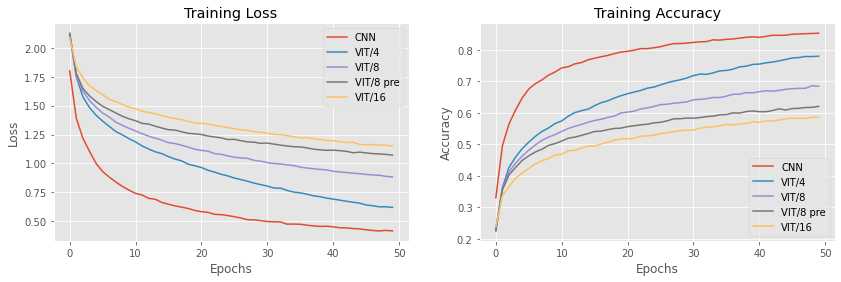

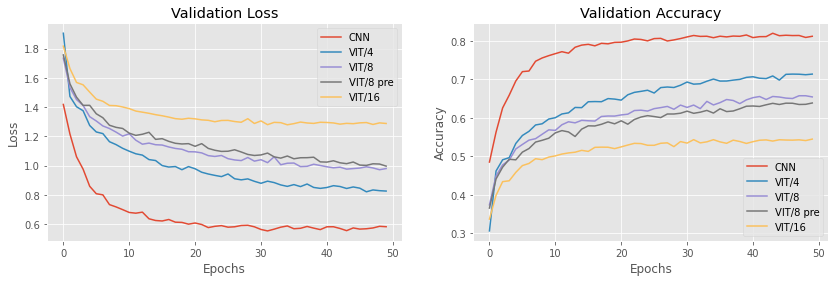

In [22]:
legends = ['CNN', 'VIT/4', 'VIT/8', 'VIT/8 pre', 'VIT/16']
histories = [history_cnn, history_vit_4x4, 
             history_vit_8x8, history_vit_8x8_pre, history_vit_16x16]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])

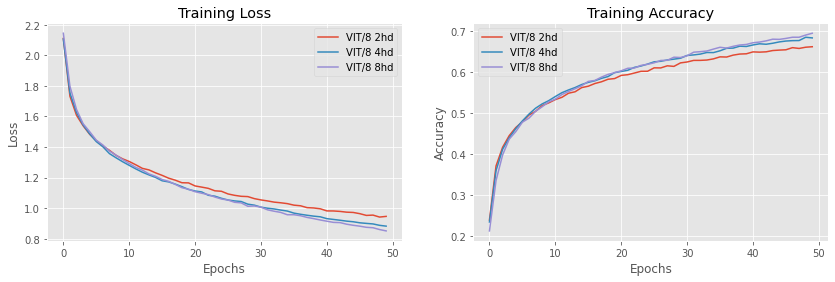

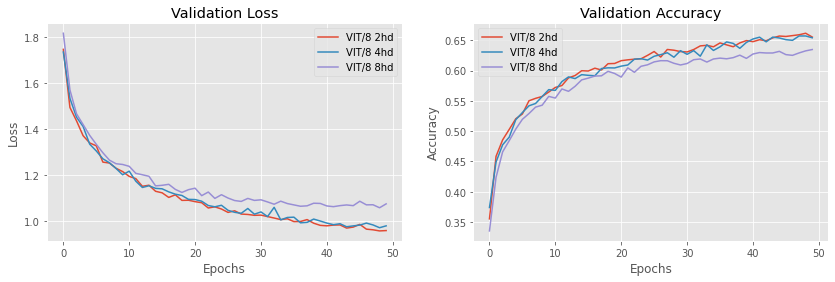

In [23]:
legends = ['VIT/8 2hd', 'VIT/8 4hd', 'VIT/8 8hd']
histories = [history_vit_8x8_2hd, history_vit_8x8, history_vit_8x8_8hd]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])

**Experiment 8**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 2

In [24]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd')

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_7 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 2/50
196/196 [==============================] - 7s 34ms/step - loss: 1.7500 - sparse_categorical_accuracy: 0.3527 - val_loss: 1.4578 - val_sparse_categorical_accuracy: 0.4671


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 3/50
196/196 [==============================] - 7s 34ms/step - loss: 1.5822 - sparse_categorical_accuracy: 0.4225 - val_loss: 1.3990 - val_sparse_categorical_accuracy: 0.4887


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 4/50
196/196 [==============================] - 7s 34ms/step - loss: 1.4984 - sparse_categorical_accuracy: 0.4489 - val_loss: 1.3670 - val_sparse_categorical_accuracy: 0.5027


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 5/50
196/196 [==============================] - 7s 34ms/step - loss: 1.4292 - sparse_categorical_accuracy: 0.4821 - val_loss: 1.3252 - val_sparse_categorical_accuracy: 0.5257


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 6/50
196/196 [==============================] - 7s 34ms/step - loss: 1.3860 - sparse_categorical_accuracy: 0.4983 - val_loss: 1.2334 - val_sparse_categorical_accuracy: 0.5486


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 7/50
196/196 [==============================] - 7s 35ms/step - loss: 1.3368 - sparse_categorical_accuracy: 0.5191 - val_loss: 1.2043 - val_sparse_categorical_accuracy: 0.5674


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 8/50
196/196 [==============================] - 7s 34ms/step - loss: 1.3024 - sparse_categorical_accuracy: 0.5326 - val_loss: 1.1622 - val_sparse_categorical_accuracy: 0.5786


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 9/50
196/196 [==============================] - 7s 34ms/step - loss: 1.2795 - sparse_categorical_accuracy: 0.5380 - val_loss: 1.1455 - val_sparse_categorical_accuracy: 0.5858


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 10/50
196/196 [==============================] - 7s 35ms/step - loss: 1.2277 - sparse_categorical_accuracy: 0.5599 - val_loss: 1.1285 - val_sparse_categorical_accuracy: 0.5944


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 11/50
196/196 [==============================] - 7s 34ms/step - loss: 1.1889 - sparse_categorical_accuracy: 0.5742 - val_loss: 1.1072 - val_sparse_categorical_accuracy: 0.6008


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 12/50
196/196 [==============================] - 7s 34ms/step - loss: 1.1630 - sparse_categorical_accuracy: 0.5832 - val_loss: 1.0765 - val_sparse_categorical_accuracy: 0.6172


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 13/50
196/196 [==============================] - 7s 34ms/step - loss: 1.1552 - sparse_categorical_accuracy: 0.5853 - val_loss: 1.0968 - val_sparse_categorical_accuracy: 0.6075
Epoch 14/50
196/196 [==============================] - 7s 33ms/step - loss: 1.1087 - sparse_categorical_accuracy: 0.6038 - val_loss: 1.0564 - val_sparse_categorical_accuracy: 0.6244


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 15/50
196/196 [==============================] - 7s 34ms/step - loss: 1.0929 - sparse_categorical_accuracy: 0.6091 - val_loss: 1.0191 - val_sparse_categorical_accuracy: 0.6391


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 16/50
196/196 [==============================] - 7s 34ms/step - loss: 1.0614 - sparse_categorical_accuracy: 0.6215 - val_loss: 1.0004 - val_sparse_categorical_accuracy: 0.6394


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 17/50
196/196 [==============================] - 7s 34ms/step - loss: 1.0411 - sparse_categorical_accuracy: 0.6296 - val_loss: 0.9725 - val_sparse_categorical_accuracy: 0.6578


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 18/50
196/196 [==============================] - 7s 34ms/step - loss: 1.0145 - sparse_categorical_accuracy: 0.6379 - val_loss: 0.9688 - val_sparse_categorical_accuracy: 0.6561
Epoch 19/50
196/196 [==============================] - 7s 34ms/step - loss: 1.0026 - sparse_categorical_accuracy: 0.6448 - val_loss: 0.9571 - val_sparse_categorical_accuracy: 0.6583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 20/50
196/196 [==============================] - 7s 34ms/step - loss: 0.9767 - sparse_categorical_accuracy: 0.6550 - val_loss: 0.9485 - val_sparse_categorical_accuracy: 0.6652


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 21/50
196/196 [==============================] - 7s 34ms/step - loss: 0.9547 - sparse_categorical_accuracy: 0.6600 - val_loss: 0.9322 - val_sparse_categorical_accuracy: 0.6695


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 22/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9340 - sparse_categorical_accuracy: 0.6657 - val_loss: 0.9251 - val_sparse_categorical_accuracy: 0.6752


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 23/50
196/196 [==============================] - 7s 34ms/step - loss: 0.9265 - sparse_categorical_accuracy: 0.6713 - val_loss: 0.9204 - val_sparse_categorical_accuracy: 0.6716
Epoch 24/50
196/196 [==============================] - 7s 34ms/step - loss: 0.8917 - sparse_categorical_accuracy: 0.6830 - val_loss: 0.8977 - val_sparse_categorical_accuracy: 0.6806


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 25/50
196/196 [==============================] - 7s 34ms/step - loss: 0.8823 - sparse_categorical_accuracy: 0.6843 - val_loss: 0.9216 - val_sparse_categorical_accuracy: 0.6741
Epoch 26/50
196/196 [==============================] - 7s 34ms/step - loss: 0.8799 - sparse_categorical_accuracy: 0.6877 - val_loss: 0.8936 - val_sparse_categorical_accuracy: 0.6849


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 27/50
196/196 [==============================] - 7s 34ms/step - loss: 0.8662 - sparse_categorical_accuracy: 0.6906 - val_loss: 0.8864 - val_sparse_categorical_accuracy: 0.6840
Epoch 28/50
196/196 [==============================] - 7s 34ms/step - loss: 0.8458 - sparse_categorical_accuracy: 0.6966 - val_loss: 0.8933 - val_sparse_categorical_accuracy: 0.6850


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 29/50
196/196 [==============================] - 7s 34ms/step - loss: 0.8308 - sparse_categorical_accuracy: 0.7042 - val_loss: 0.8648 - val_sparse_categorical_accuracy: 0.6921


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 30/50
196/196 [==============================] - 7s 34ms/step - loss: 0.8186 - sparse_categorical_accuracy: 0.7090 - val_loss: 0.8741 - val_sparse_categorical_accuracy: 0.6910
Epoch 31/50
196/196 [==============================] - 7s 34ms/step - loss: 0.8089 - sparse_categorical_accuracy: 0.7112 - val_loss: 0.8606 - val_sparse_categorical_accuracy: 0.6977


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 32/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7935 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.8627 - val_sparse_categorical_accuracy: 0.6978


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 33/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7725 - sparse_categorical_accuracy: 0.7286 - val_loss: 0.8487 - val_sparse_categorical_accuracy: 0.7030


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 34/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7709 - sparse_categorical_accuracy: 0.7254 - val_loss: 0.8541 - val_sparse_categorical_accuracy: 0.7008
Epoch 35/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7489 - sparse_categorical_accuracy: 0.7331 - val_loss: 0.8340 - val_sparse_categorical_accuracy: 0.7030
Epoch 36/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7383 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.8364 - val_sparse_categorical_accuracy: 0.7042


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 37/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7420 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.8415 - val_sparse_categorical_accuracy: 0.7070


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 38/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7209 - sparse_categorical_accuracy: 0.7414 - val_loss: 0.8295 - val_sparse_categorical_accuracy: 0.7058
Epoch 39/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7213 - sparse_categorical_accuracy: 0.7409 - val_loss: 0.8329 - val_sparse_categorical_accuracy: 0.7014
Epoch 40/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6971 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.8277 - val_sparse_categorical_accuracy: 0.7081


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 41/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7023 - sparse_categorical_accuracy: 0.7510 - val_loss: 0.8232 - val_sparse_categorical_accuracy: 0.7064
Epoch 42/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6846 - sparse_categorical_accuracy: 0.7567 - val_loss: 0.8118 - val_sparse_categorical_accuracy: 0.7141


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 43/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6748 - sparse_categorical_accuracy: 0.7606 - val_loss: 0.8206 - val_sparse_categorical_accuracy: 0.7127
Epoch 44/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6706 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.8130 - val_sparse_categorical_accuracy: 0.7116
Epoch 45/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6709 - sparse_categorical_accuracy: 0.7635 - val_loss: 0.8014 - val_sparse_categorical_accuracy: 0.7187


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 46/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6604 - sparse_categorical_accuracy: 0.7654 - val_loss: 0.8243 - val_sparse_categorical_accuracy: 0.7117
Epoch 47/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6457 - sparse_categorical_accuracy: 0.7739 - val_loss: 0.8114 - val_sparse_categorical_accuracy: 0.7159
Epoch 48/50
196/196 [==============================] - 7s 35ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.7720 - val_loss: 0.8230 - val_sparse_categorical_accuracy: 0.7141
Epoch 49/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6302 - sparse_categorical_accuracy: 0.7808 - val_loss: 0.7931 - val_sparse_categorical_accuracy: 0.7202


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 50/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6227 - sparse_categorical_accuracy: 0.7794 - val_loss: 0.8016 - val_sparse_categorical_accuracy: 0.7157
Total training time 574.30828332901 seconds


**Experiment 9**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 8


In [25]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=8,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_8hd = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd')

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_8 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 2/50
196/196 [==============================] - 14s 69ms/step - loss: 1.8288 - sparse_categorical_accuracy: 0.3188 - val_loss: 1.5120 - val_sparse_categorical_accuracy: 0.4447


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 3/50
196/196 [==============================] - 14s 69ms/step - loss: 1.6227 - sparse_categorical_accuracy: 0.3994 - val_loss: 1.4482 - val_sparse_categorical_accuracy: 0.4657


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 4/50
196/196 [==============================] - 14s 69ms/step - loss: 1.5219 - sparse_categorical_accuracy: 0.4462 - val_loss: 1.3562 - val_sparse_categorical_accuracy: 0.5032


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 5/50
196/196 [==============================] - 14s 69ms/step - loss: 1.4471 - sparse_categorical_accuracy: 0.4762 - val_loss: 1.2590 - val_sparse_categorical_accuracy: 0.5406


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 6/50
196/196 [==============================] - 14s 69ms/step - loss: 1.3727 - sparse_categorical_accuracy: 0.4993 - val_loss: 1.2269 - val_sparse_categorical_accuracy: 0.5534


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 7/50
196/196 [==============================] - 14s 70ms/step - loss: 1.3205 - sparse_categorical_accuracy: 0.5201 - val_loss: 1.2016 - val_sparse_categorical_accuracy: 0.5642


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 8/50
196/196 [==============================] - 14s 69ms/step - loss: 1.2705 - sparse_categorical_accuracy: 0.5432 - val_loss: 1.2161 - val_sparse_categorical_accuracy: 0.5628
Epoch 9/50
196/196 [==============================] - 13s 68ms/step - loss: 1.2396 - sparse_categorical_accuracy: 0.5530 - val_loss: 1.1345 - val_sparse_categorical_accuracy: 0.5892


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 10/50
196/196 [==============================] - 14s 69ms/step - loss: 1.1969 - sparse_categorical_accuracy: 0.5706 - val_loss: 1.1038 - val_sparse_categorical_accuracy: 0.6070


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 11/50
196/196 [==============================] - 14s 69ms/step - loss: 1.1631 - sparse_categorical_accuracy: 0.5837 - val_loss: 1.1016 - val_sparse_categorical_accuracy: 0.6011
Epoch 12/50
196/196 [==============================] - 14s 69ms/step - loss: 1.1453 - sparse_categorical_accuracy: 0.5914 - val_loss: 1.0838 - val_sparse_categorical_accuracy: 0.6118


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 13/50
196/196 [==============================] - 14s 69ms/step - loss: 1.1054 - sparse_categorical_accuracy: 0.6040 - val_loss: 1.0947 - val_sparse_categorical_accuracy: 0.6059
Epoch 14/50
196/196 [==============================] - 14s 69ms/step - loss: 1.0890 - sparse_categorical_accuracy: 0.6104 - val_loss: 1.0484 - val_sparse_categorical_accuracy: 0.6220


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 15/50
196/196 [==============================] - 14s 69ms/step - loss: 1.0711 - sparse_categorical_accuracy: 0.6169 - val_loss: 1.0242 - val_sparse_categorical_accuracy: 0.6369


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 16/50
196/196 [==============================] - 14s 69ms/step - loss: 1.0413 - sparse_categorical_accuracy: 0.6278 - val_loss: 1.0196 - val_sparse_categorical_accuracy: 0.6335
Epoch 17/50
196/196 [==============================] - 14s 70ms/step - loss: 1.0202 - sparse_categorical_accuracy: 0.6357 - val_loss: 1.0194 - val_sparse_categorical_accuracy: 0.6355
Epoch 18/50
196/196 [==============================] - 14s 69ms/step - loss: 0.9964 - sparse_categorical_accuracy: 0.6432 - val_loss: 1.0081 - val_sparse_categorical_accuracy: 0.6467


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 19/50
196/196 [==============================] - 14s 69ms/step - loss: 0.9708 - sparse_categorical_accuracy: 0.6534 - val_loss: 0.9951 - val_sparse_categorical_accuracy: 0.6429
Epoch 20/50
196/196 [==============================] - 14s 69ms/step - loss: 0.9731 - sparse_categorical_accuracy: 0.6491 - val_loss: 0.9914 - val_sparse_categorical_accuracy: 0.6466
Epoch 21/50
196/196 [==============================] - 14s 69ms/step - loss: 0.9413 - sparse_categorical_accuracy: 0.6648 - val_loss: 0.9865 - val_sparse_categorical_accuracy: 0.6535


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 22/50
196/196 [==============================] - 14s 70ms/step - loss: 0.9257 - sparse_categorical_accuracy: 0.6663 - val_loss: 0.9759 - val_sparse_categorical_accuracy: 0.6527
Epoch 23/50
196/196 [==============================] - 14s 69ms/step - loss: 0.9068 - sparse_categorical_accuracy: 0.6765 - val_loss: 0.9567 - val_sparse_categorical_accuracy: 0.6634


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 24/50
196/196 [==============================] - 14s 69ms/step - loss: 0.8911 - sparse_categorical_accuracy: 0.6843 - val_loss: 0.9595 - val_sparse_categorical_accuracy: 0.6578
Epoch 25/50
196/196 [==============================] - 14s 69ms/step - loss: 0.8889 - sparse_categorical_accuracy: 0.6816 - val_loss: 0.9514 - val_sparse_categorical_accuracy: 0.6637


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 26/50
196/196 [==============================] - 14s 69ms/step - loss: 0.8694 - sparse_categorical_accuracy: 0.6895 - val_loss: 0.9446 - val_sparse_categorical_accuracy: 0.6632
Epoch 27/50
196/196 [==============================] - 14s 69ms/step - loss: 0.8566 - sparse_categorical_accuracy: 0.6933 - val_loss: 0.9572 - val_sparse_categorical_accuracy: 0.6658


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 28/50
196/196 [==============================] - 13s 68ms/step - loss: 0.8365 - sparse_categorical_accuracy: 0.7021 - val_loss: 0.9154 - val_sparse_categorical_accuracy: 0.6773


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 29/50
196/196 [==============================] - 14s 69ms/step - loss: 0.8234 - sparse_categorical_accuracy: 0.7075 - val_loss: 0.9278 - val_sparse_categorical_accuracy: 0.6791


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 30/50
196/196 [==============================] - 14s 69ms/step - loss: 0.8046 - sparse_categorical_accuracy: 0.7130 - val_loss: 0.9113 - val_sparse_categorical_accuracy: 0.6792


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 31/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7845 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.9285 - val_sparse_categorical_accuracy: 0.6764
Epoch 32/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7773 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.9324 - val_sparse_categorical_accuracy: 0.6706
Epoch 33/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7675 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.9425 - val_sparse_categorical_accuracy: 0.6729
Epoch 34/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7665 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.9184 - val_sparse_categorical_accuracy: 0.6734
Epoch 35/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7388 - sparse_categorical_accuracy: 0.7361 - val_loss: 0.9307 - val_sparse_categorical_accuracy: 0.6827


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 36/50
196/196 [==============================] - 13s 68ms/step - loss: 0.7420 - sparse_categorical_accuracy: 0.7341 - val_loss: 0.9160 - val_sparse_categorical_accuracy: 0.6872


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 37/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7301 - sparse_categorical_accuracy: 0.7415 - val_loss: 0.8959 - val_sparse_categorical_accuracy: 0.6840
Epoch 38/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7178 - sparse_categorical_accuracy: 0.7430 - val_loss: 0.9210 - val_sparse_categorical_accuracy: 0.6789
Epoch 39/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7094 - sparse_categorical_accuracy: 0.7458 - val_loss: 0.9235 - val_sparse_categorical_accuracy: 0.6847
Epoch 40/50
196/196 [==============================] - 13s 68ms/step - loss: 0.6948 - sparse_categorical_accuracy: 0.7522 - val_loss: 0.9147 - val_sparse_categorical_accuracy: 0.6877


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 41/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6772 - sparse_categorical_accuracy: 0.7594 - val_loss: 0.8847 - val_sparse_categorical_accuracy: 0.6955


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 42/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6671 - sparse_categorical_accuracy: 0.7628 - val_loss: 0.9164 - val_sparse_categorical_accuracy: 0.6899
Epoch 43/50
196/196 [==============================] - 14s 70ms/step - loss: 0.6544 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.8822 - val_sparse_categorical_accuracy: 0.6928
Epoch 44/50
196/196 [==============================] - 14s 70ms/step - loss: 0.6564 - sparse_categorical_accuracy: 0.7677 - val_loss: 0.8819 - val_sparse_categorical_accuracy: 0.6884
Epoch 45/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6469 - sparse_categorical_accuracy: 0.7686 - val_loss: 0.8931 - val_sparse_categorical_accuracy: 0.6946
Epoch 46/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.7743 - val_loss: 0.8856 - val_sparse_categorical_accuracy: 0.6934
Epoch 47/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6191 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 48/50
196/196 [==============================] - 14s 70ms/step - loss: 0.6218 - sparse_categorical_accuracy: 0.7777 - val_loss: 0.8842 - val_sparse_categorical_accuracy: 0.6987


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 49/50
196/196 [==============================] - 14s 70ms/step - loss: 0.6012 - sparse_categorical_accuracy: 0.7855 - val_loss: 0.8895 - val_sparse_categorical_accuracy: 0.6917
Epoch 50/50
196/196 [==============================] - 14s 69ms/step - loss: 0.5983 - sparse_categorical_accuracy: 0.7872 - val_loss: 0.8832 - val_sparse_categorical_accuracy: 0.7002


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Total training time 873.8543713092804 seconds


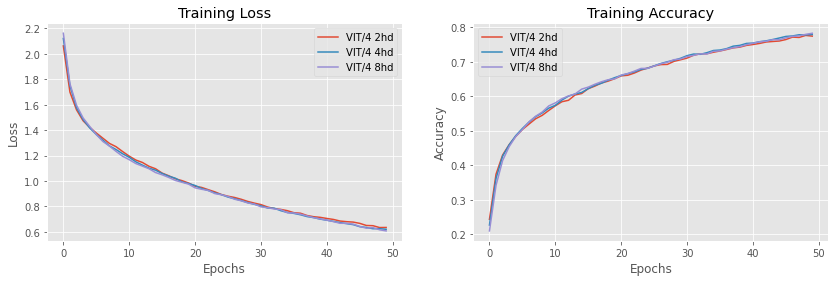

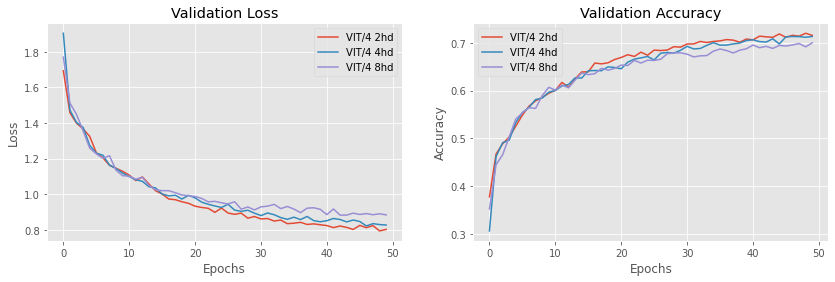

In [26]:
legends = ['VIT/4 2hd', 'VIT/4 4hd', 'VIT/4 8hd']
histories = [history_vit_4x4_2hd, history_vit_4x4, history_vit_4x4_8hd]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])

**Experiment 10**  
Model : VIT  
Preprocessing : False  
Batch size : 512  
Patch : 4x4  
Heads : 2


In [27]:
batch_size = 512
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd_bs512 = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512')

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_10[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_9 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 2/50
98/98 [==============================] - 6s 61ms/step - loss: 1.9308 - sparse_categorical_accuracy: 0.2896 - val_loss: 1.6279 - val_sparse_categorical_accuracy: 0.4204


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 3/50
98/98 [==============================] - 6s 62ms/step - loss: 1.7302 - sparse_categorical_accuracy: 0.3683 - val_loss: 1.4493 - val_sparse_categorical_accuracy: 0.4747


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 4/50
98/98 [==============================] - 6s 62ms/step - loss: 1.5884 - sparse_categorical_accuracy: 0.4174 - val_loss: 1.3826 - val_sparse_categorical_accuracy: 0.5026


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 5/50
98/98 [==============================] - 6s 62ms/step - loss: 1.5029 - sparse_categorical_accuracy: 0.4556 - val_loss: 1.3218 - val_sparse_categorical_accuracy: 0.5177


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 6/50
98/98 [==============================] - 6s 62ms/step - loss: 1.4489 - sparse_categorical_accuracy: 0.4735 - val_loss: 1.2719 - val_sparse_categorical_accuracy: 0.5328


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 7/50
98/98 [==============================] - 6s 62ms/step - loss: 1.3968 - sparse_categorical_accuracy: 0.4911 - val_loss: 1.2330 - val_sparse_categorical_accuracy: 0.5445


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 8/50
98/98 [==============================] - 6s 62ms/step - loss: 1.3462 - sparse_categorical_accuracy: 0.5141 - val_loss: 1.2207 - val_sparse_categorical_accuracy: 0.5620


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 9/50
98/98 [==============================] - 6s 61ms/step - loss: 1.3248 - sparse_categorical_accuracy: 0.5242 - val_loss: 1.1670 - val_sparse_categorical_accuracy: 0.5795


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 10/50
98/98 [==============================] - 6s 62ms/step - loss: 1.2788 - sparse_categorical_accuracy: 0.5415 - val_loss: 1.1536 - val_sparse_categorical_accuracy: 0.5824


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 11/50
98/98 [==============================] - 6s 62ms/step - loss: 1.2551 - sparse_categorical_accuracy: 0.5481 - val_loss: 1.1718 - val_sparse_categorical_accuracy: 0.5793
Epoch 12/50
98/98 [==============================] - 6s 62ms/step - loss: 1.2221 - sparse_categorical_accuracy: 0.5618 - val_loss: 1.1117 - val_sparse_categorical_accuracy: 0.5986


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 13/50
98/98 [==============================] - 6s 61ms/step - loss: 1.1905 - sparse_categorical_accuracy: 0.5762 - val_loss: 1.0795 - val_sparse_categorical_accuracy: 0.6080


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 14/50
98/98 [==============================] - 6s 61ms/step - loss: 1.1671 - sparse_categorical_accuracy: 0.5848 - val_loss: 1.0797 - val_sparse_categorical_accuracy: 0.6113


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 15/50
98/98 [==============================] - 6s 61ms/step - loss: 1.1503 - sparse_categorical_accuracy: 0.5881 - val_loss: 1.0499 - val_sparse_categorical_accuracy: 0.6219


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 16/50
98/98 [==============================] - 6s 63ms/step - loss: 1.1160 - sparse_categorical_accuracy: 0.6002 - val_loss: 1.0383 - val_sparse_categorical_accuracy: 0.6288


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 17/50
98/98 [==============================] - 6s 62ms/step - loss: 1.1058 - sparse_categorical_accuracy: 0.6073 - val_loss: 1.0376 - val_sparse_categorical_accuracy: 0.6291


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 18/50
98/98 [==============================] - 6s 61ms/step - loss: 1.0807 - sparse_categorical_accuracy: 0.6142 - val_loss: 1.0183 - val_sparse_categorical_accuracy: 0.6294


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 19/50
98/98 [==============================] - 6s 62ms/step - loss: 1.0605 - sparse_categorical_accuracy: 0.6187 - val_loss: 0.9941 - val_sparse_categorical_accuracy: 0.6460


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 20/50
98/98 [==============================] - 6s 61ms/step - loss: 1.0399 - sparse_categorical_accuracy: 0.6279 - val_loss: 0.9803 - val_sparse_categorical_accuracy: 0.6551


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 21/50
98/98 [==============================] - 6s 62ms/step - loss: 1.0157 - sparse_categorical_accuracy: 0.6379 - val_loss: 0.9581 - val_sparse_categorical_accuracy: 0.6599


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 22/50
98/98 [==============================] - 6s 62ms/step - loss: 0.9972 - sparse_categorical_accuracy: 0.6441 - val_loss: 0.9507 - val_sparse_categorical_accuracy: 0.6625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 23/50
98/98 [==============================] - 6s 62ms/step - loss: 0.9808 - sparse_categorical_accuracy: 0.6478 - val_loss: 0.9462 - val_sparse_categorical_accuracy: 0.6671


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 24/50
98/98 [==============================] - 6s 62ms/step - loss: 0.9541 - sparse_categorical_accuracy: 0.6624 - val_loss: 0.9435 - val_sparse_categorical_accuracy: 0.6649
Epoch 25/50
98/98 [==============================] - 6s 61ms/step - loss: 0.9369 - sparse_categorical_accuracy: 0.6653 - val_loss: 0.9239 - val_sparse_categorical_accuracy: 0.6713


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 26/50
98/98 [==============================] - 6s 62ms/step - loss: 0.9181 - sparse_categorical_accuracy: 0.6721 - val_loss: 0.9256 - val_sparse_categorical_accuracy: 0.6713
Epoch 27/50
98/98 [==============================] - 6s 62ms/step - loss: 0.9156 - sparse_categorical_accuracy: 0.6708 - val_loss: 0.9107 - val_sparse_categorical_accuracy: 0.6742


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 28/50
98/98 [==============================] - 6s 63ms/step - loss: 0.9013 - sparse_categorical_accuracy: 0.6759 - val_loss: 0.9324 - val_sparse_categorical_accuracy: 0.6670
Epoch 29/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8890 - sparse_categorical_accuracy: 0.6853 - val_loss: 0.9180 - val_sparse_categorical_accuracy: 0.6782


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 30/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8742 - sparse_categorical_accuracy: 0.6877 - val_loss: 0.8907 - val_sparse_categorical_accuracy: 0.6894


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 31/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8585 - sparse_categorical_accuracy: 0.6961 - val_loss: 0.8884 - val_sparse_categorical_accuracy: 0.6878
Epoch 32/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8460 - sparse_categorical_accuracy: 0.6974 - val_loss: 0.8849 - val_sparse_categorical_accuracy: 0.6876
Epoch 33/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8350 - sparse_categorical_accuracy: 0.7023 - val_loss: 0.8673 - val_sparse_categorical_accuracy: 0.6937


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 34/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8105 - sparse_categorical_accuracy: 0.7143 - val_loss: 0.8638 - val_sparse_categorical_accuracy: 0.6968


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 35/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8120 - sparse_categorical_accuracy: 0.7082 - val_loss: 0.8611 - val_sparse_categorical_accuracy: 0.7007


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 36/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8021 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.8602 - val_sparse_categorical_accuracy: 0.6990
Epoch 37/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7884 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.8610 - val_sparse_categorical_accuracy: 0.6950
Epoch 38/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7765 - sparse_categorical_accuracy: 0.7244 - val_loss: 0.8578 - val_sparse_categorical_accuracy: 0.6988
Epoch 39/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7693 - sparse_categorical_accuracy: 0.7303 - val_loss: 0.8544 - val_sparse_categorical_accuracy: 0.6998
Epoch 40/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7481 - sparse_categorical_accuracy: 0.7328 - val_loss: 0.8380 - val_sparse_categorical_accuracy: 0.7021


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 41/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7463 - sparse_categorical_accuracy: 0.7353 - val_loss: 0.8438 - val_sparse_categorical_accuracy: 0.7080


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 42/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7347 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.8443 - val_sparse_categorical_accuracy: 0.7048
Epoch 43/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7336 - sparse_categorical_accuracy: 0.7374 - val_loss: 0.8395 - val_sparse_categorical_accuracy: 0.7094


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 44/50
98/98 [==============================] - 6s 63ms/step - loss: 0.7126 - sparse_categorical_accuracy: 0.7464 - val_loss: 0.8247 - val_sparse_categorical_accuracy: 0.7147


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 45/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7005 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.8347 - val_sparse_categorical_accuracy: 0.7106
Epoch 46/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7050 - sparse_categorical_accuracy: 0.7491 - val_loss: 0.8259 - val_sparse_categorical_accuracy: 0.7104
Epoch 47/50
98/98 [==============================] - 6s 63ms/step - loss: 0.6963 - sparse_categorical_accuracy: 0.7512 - val_loss: 0.8292 - val_sparse_categorical_accuracy: 0.7116
Epoch 48/50
98/98 [==============================] - 6s 62ms/step - loss: 0.6862 - sparse_categorical_accuracy: 0.7549 - val_loss: 0.8275 - val_sparse_categorical_accuracy: 0.7091
Epoch 49/50
98/98 [==============================] - 6s 63ms/step - loss: 0.6769 - sparse_categorical_accuracy: 0.7610 - val_loss: 0.8228 - val_sparse_categorical_accuracy: 0.7129
Epoch 50/50
98/98 [==============================] - 6s 63ms/step - loss: 0.6870 - sparse_categorica

**Experiment 11**  
Model : VIT  
Preprocessing : False  
Batch size : 1024  
Patch : 4x4  
Heads : 2


In [28]:
batch_size = 1024
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd_bs1024 = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024')

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_11[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_10 (Patches)            (None, None, 48)     0           resize[0][0]                     
___________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 2/50
49/49 [==============================] - 6s 113ms/step - loss: 2.0272 - sparse_categorical_accuracy: 0.2498 - val_loss: 1.7617 - val_sparse_categorical_accuracy: 0.3571


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 3/50
49/49 [==============================] - 6s 114ms/step - loss: 1.8363 - sparse_categorical_accuracy: 0.3256 - val_loss: 1.5930 - val_sparse_categorical_accuracy: 0.4235


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 4/50
49/49 [==============================] - 6s 116ms/step - loss: 1.7061 - sparse_categorical_accuracy: 0.3730 - val_loss: 1.4896 - val_sparse_categorical_accuracy: 0.4524


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 5/50
49/49 [==============================] - 6s 115ms/step - loss: 1.6188 - sparse_categorical_accuracy: 0.4095 - val_loss: 1.4378 - val_sparse_categorical_accuracy: 0.4774


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 6/50
49/49 [==============================] - 6s 115ms/step - loss: 1.5352 - sparse_categorical_accuracy: 0.4437 - val_loss: 1.4206 - val_sparse_categorical_accuracy: 0.4830


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 7/50
49/49 [==============================] - 6s 115ms/step - loss: 1.5000 - sparse_categorical_accuracy: 0.4541 - val_loss: 1.3304 - val_sparse_categorical_accuracy: 0.5176


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 8/50
49/49 [==============================] - 6s 114ms/step - loss: 1.4372 - sparse_categorical_accuracy: 0.4779 - val_loss: 1.2951 - val_sparse_categorical_accuracy: 0.5238


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 9/50
49/49 [==============================] - 6s 114ms/step - loss: 1.4014 - sparse_categorical_accuracy: 0.4893 - val_loss: 1.2512 - val_sparse_categorical_accuracy: 0.5386


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 10/50
49/49 [==============================] - 6s 114ms/step - loss: 1.3534 - sparse_categorical_accuracy: 0.5076 - val_loss: 1.2489 - val_sparse_categorical_accuracy: 0.5415


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 11/50
49/49 [==============================] - 6s 114ms/step - loss: 1.3340 - sparse_categorical_accuracy: 0.5160 - val_loss: 1.2069 - val_sparse_categorical_accuracy: 0.5577


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 12/50
49/49 [==============================] - 6s 114ms/step - loss: 1.3037 - sparse_categorical_accuracy: 0.5282 - val_loss: 1.1996 - val_sparse_categorical_accuracy: 0.5681


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 13/50
49/49 [==============================] - 6s 114ms/step - loss: 1.2866 - sparse_categorical_accuracy: 0.5364 - val_loss: 1.1735 - val_sparse_categorical_accuracy: 0.5755


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 14/50
49/49 [==============================] - 6s 116ms/step - loss: 1.2448 - sparse_categorical_accuracy: 0.5496 - val_loss: 1.1684 - val_sparse_categorical_accuracy: 0.5763


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 15/50
49/49 [==============================] - 6s 116ms/step - loss: 1.2369 - sparse_categorical_accuracy: 0.5555 - val_loss: 1.1131 - val_sparse_categorical_accuracy: 0.5936


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 16/50
49/49 [==============================] - 6s 115ms/step - loss: 1.2019 - sparse_categorical_accuracy: 0.5678 - val_loss: 1.0945 - val_sparse_categorical_accuracy: 0.6032


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 17/50
49/49 [==============================] - 6s 115ms/step - loss: 1.1713 - sparse_categorical_accuracy: 0.5778 - val_loss: 1.0845 - val_sparse_categorical_accuracy: 0.6060


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 18/50
49/49 [==============================] - 6s 116ms/step - loss: 1.1734 - sparse_categorical_accuracy: 0.5787 - val_loss: 1.0604 - val_sparse_categorical_accuracy: 0.6181


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 19/50
49/49 [==============================] - 6s 115ms/step - loss: 1.1317 - sparse_categorical_accuracy: 0.5970 - val_loss: 1.0456 - val_sparse_categorical_accuracy: 0.6204


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 20/50
49/49 [==============================] - 6s 116ms/step - loss: 1.1054 - sparse_categorical_accuracy: 0.6047 - val_loss: 1.0380 - val_sparse_categorical_accuracy: 0.6230


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 21/50
49/49 [==============================] - 6s 116ms/step - loss: 1.0845 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.0262 - val_sparse_categorical_accuracy: 0.6323


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 22/50
49/49 [==============================] - 6s 116ms/step - loss: 1.0695 - sparse_categorical_accuracy: 0.6168 - val_loss: 1.0014 - val_sparse_categorical_accuracy: 0.6409


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 23/50
49/49 [==============================] - 6s 116ms/step - loss: 1.0599 - sparse_categorical_accuracy: 0.6211 - val_loss: 0.9964 - val_sparse_categorical_accuracy: 0.6419


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 24/50
49/49 [==============================] - 6s 115ms/step - loss: 1.0392 - sparse_categorical_accuracy: 0.6296 - val_loss: 0.9820 - val_sparse_categorical_accuracy: 0.6476


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 25/50
49/49 [==============================] - 6s 116ms/step - loss: 1.0270 - sparse_categorical_accuracy: 0.6369 - val_loss: 0.9654 - val_sparse_categorical_accuracy: 0.6481


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 26/50
49/49 [==============================] - 6s 116ms/step - loss: 0.9988 - sparse_categorical_accuracy: 0.6423 - val_loss: 0.9813 - val_sparse_categorical_accuracy: 0.6469
Epoch 27/50
49/49 [==============================] - 6s 115ms/step - loss: 1.0005 - sparse_categorical_accuracy: 0.6430 - val_loss: 0.9629 - val_sparse_categorical_accuracy: 0.6550


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 28/50
49/49 [==============================] - 6s 116ms/step - loss: 0.9672 - sparse_categorical_accuracy: 0.6560 - val_loss: 0.9405 - val_sparse_categorical_accuracy: 0.6638


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 29/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9664 - sparse_categorical_accuracy: 0.6587 - val_loss: 0.9282 - val_sparse_categorical_accuracy: 0.6685


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 30/50
49/49 [==============================] - 6s 115ms/step - loss: 0.9457 - sparse_categorical_accuracy: 0.6606 - val_loss: 0.9331 - val_sparse_categorical_accuracy: 0.6679
Epoch 31/50
49/49 [==============================] - 6s 115ms/step - loss: 0.9312 - sparse_categorical_accuracy: 0.6668 - val_loss: 0.9162 - val_sparse_categorical_accuracy: 0.6711


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 32/50
49/49 [==============================] - 6s 116ms/step - loss: 0.9198 - sparse_categorical_accuracy: 0.6746 - val_loss: 0.9194 - val_sparse_categorical_accuracy: 0.6731


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 33/50
49/49 [==============================] - 6s 116ms/step - loss: 0.9012 - sparse_categorical_accuracy: 0.6779 - val_loss: 0.9155 - val_sparse_categorical_accuracy: 0.6710
Epoch 34/50
49/49 [==============================] - 6s 116ms/step - loss: 0.8961 - sparse_categorical_accuracy: 0.6826 - val_loss: 0.8934 - val_sparse_categorical_accuracy: 0.6823


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 35/50
49/49 [==============================] - 6s 115ms/step - loss: 0.8815 - sparse_categorical_accuracy: 0.6869 - val_loss: 0.8919 - val_sparse_categorical_accuracy: 0.6838


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 36/50
49/49 [==============================] - 6s 116ms/step - loss: 0.8658 - sparse_categorical_accuracy: 0.6901 - val_loss: 0.8882 - val_sparse_categorical_accuracy: 0.6850


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 37/50
49/49 [==============================] - 6s 116ms/step - loss: 0.8602 - sparse_categorical_accuracy: 0.6966 - val_loss: 0.8890 - val_sparse_categorical_accuracy: 0.6863


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 38/50
49/49 [==============================] - 6s 115ms/step - loss: 0.8449 - sparse_categorical_accuracy: 0.6997 - val_loss: 0.8806 - val_sparse_categorical_accuracy: 0.6888


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 39/50
49/49 [==============================] - 6s 116ms/step - loss: 0.8301 - sparse_categorical_accuracy: 0.7025 - val_loss: 0.8765 - val_sparse_categorical_accuracy: 0.6910


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 40/50
49/49 [==============================] - 6s 116ms/step - loss: 0.8170 - sparse_categorical_accuracy: 0.7084 - val_loss: 0.8701 - val_sparse_categorical_accuracy: 0.6911


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 41/50
49/49 [==============================] - 6s 115ms/step - loss: 0.8245 - sparse_categorical_accuracy: 0.7085 - val_loss: 0.8662 - val_sparse_categorical_accuracy: 0.6933


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 42/50
49/49 [==============================] - 6s 116ms/step - loss: 0.8094 - sparse_categorical_accuracy: 0.7135 - val_loss: 0.8575 - val_sparse_categorical_accuracy: 0.6950


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 43/50
49/49 [==============================] - 6s 115ms/step - loss: 0.7841 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.8567 - val_sparse_categorical_accuracy: 0.6936
Epoch 44/50
49/49 [==============================] - 6s 115ms/step - loss: 0.7800 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.8517 - val_sparse_categorical_accuracy: 0.7015


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 45/50
49/49 [==============================] - 6s 116ms/step - loss: 0.7713 - sparse_categorical_accuracy: 0.7274 - val_loss: 0.8526 - val_sparse_categorical_accuracy: 0.6996
Epoch 46/50
49/49 [==============================] - 6s 116ms/step - loss: 0.7655 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.8488 - val_sparse_categorical_accuracy: 0.6998
Epoch 47/50
49/49 [==============================] - 6s 117ms/step - loss: 0.7611 - sparse_categorical_accuracy: 0.7286 - val_loss: 0.8433 - val_sparse_categorical_accuracy: 0.6998
Epoch 48/50
49/49 [==============================] - 6s 117ms/step - loss: 0.7447 - sparse_categorical_accuracy: 0.7327 - val_loss: 0.8573 - val_sparse_categorical_accuracy: 0.6952
Epoch 49/50
49/49 [==============================] - 6s 116ms/step - loss: 0.7442 - sparse_categorical_accuracy: 0.7340 - val_loss: 0.8421 - val_sparse_categorical_accuracy: 0.7034


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 50/50
49/49 [==============================] - 6s 117ms/step - loss: 0.7389 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.8472 - val_sparse_categorical_accuracy: 0.7036


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Total training time 590.7741301059723 seconds


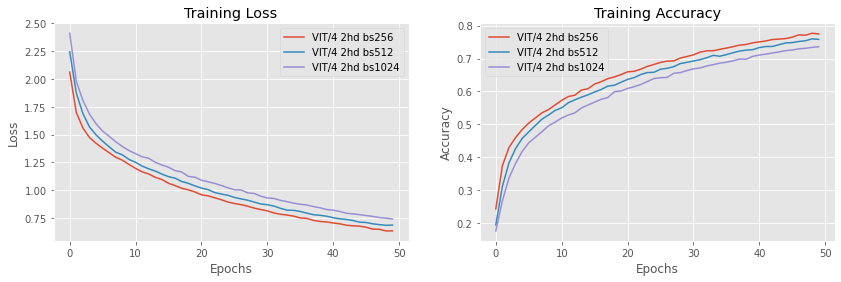

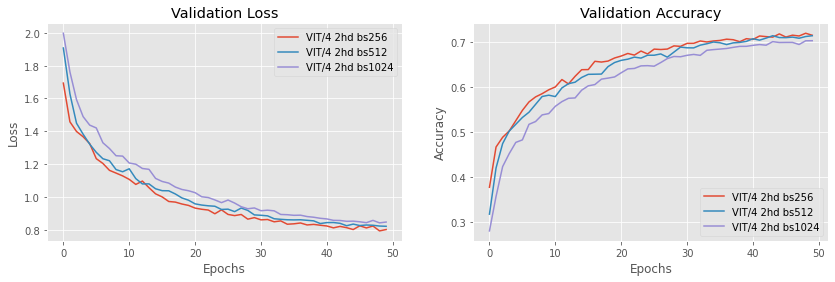

In [29]:
legends = ['VIT/4 2hd bs256', 'VIT/4 2hd bs512', 'VIT/4 2hd bs1024']
histories = [history_vit_4x4_2hd, history_vit_4x4_2hd_bs512, history_vit_4x4_2hd_bs1024]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])

**Experiment 12**  
Model : CNN  
Preprocessing : False  
Batch size : 256  
Epochs: 500

In [30]:
batch_size = 256
epochs = 500
model = SmallCNN(num_classes=num_classes, 
                 image_height=image_height, 
                 image_width=image_width,
                 preprocess=False).model()
model.summary()
history_cnn_500epoch = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch')

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0  

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 2/500
196/196 [==============================] - 4s 18ms/step - loss: 1.4372 - sparse_categorical_accuracy: 0.4753 - val_loss: 1.2374 - val_sparse_categorical_accuracy: 0.5630
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 3/500
196/196 [==============================] - 4s 18ms/step - loss: 1.2662 - sparse_categorical_accuracy: 0.5495 - val_loss: 1.0803 - val_sparse_categorical_accuracy: 0.6196
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 4/500
196/196 [==============================] - 4s 18ms/step - loss: 1.1316 - sparse_categorical_accuracy: 0.5978 - val_loss: 1.0025 - val_sparse_categorical_accuracy: 0.6425
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 5/500
196/196 [==============================] - 4s 18ms/step - loss: 1.0594 - sparse_categorical_accuracy: 0.6255 - val_loss: 0.9239 - val_sparse_categorical_accuracy: 0.6764
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 6/500
196/196 [==============================] - 4s 18ms/step - loss: 0.9831 - sparse_categorical_accuracy: 0.6544 - val_loss: 0.8699 - val_sparse_categorical_accuracy: 0.6942
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 7/500
196/196 [==============================] - 4s 18ms/step - loss: 0.9283 - sparse_categorical_accuracy: 0.6734 - val_loss: 0.8230 - val_sparse_categorical_accuracy: 0.7157
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 8/500
196/196 [==============================] - 4s 18ms/step - loss: 0.8972 - sparse_categorical_accuracy: 0.6843 - val_loss: 0.8015 - val_sparse_categorical_accuracy: 0.7227
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 9/500
196/196 [==============================] - 4s 18ms/step - loss: 0.8437 - sparse_categorical_accuracy: 0.7032 - val_loss: 0.7421 - val_sparse_categorical_accuracy: 0.7424
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 10/500
196/196 [==============================] - 4s 18ms/step - loss: 0.8162 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.7338 - val_sparse_categorical_accuracy: 0.7458
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 11/500
196/196 [==============================] - 4s 18ms/step - loss: 0.7835 - sparse_categorical_accuracy: 0.7268 - val_loss: 0.7223 - val_sparse_categorical_accuracy: 0.7519
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 12/500
196/196 [==============================] - 4s 18ms/step - loss: 0.7601 - sparse_categorical_accuracy: 0.7334 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.7599
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 13/500
196/196 [==============================] - 4s 18ms/step - loss: 0.7543 - sparse_categorical_accuracy: 0.7357 - val_loss: 0.7110 - val_sparse_categorical_accuracy: 0.7530
Epoch 14/500
196/196 [==============================] - 4s 18ms/step - loss: 0.7305 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.6785 - val_sparse_categorical_accuracy: 0.7650
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 15/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6957 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.6662 - val_sparse_categorical_accuracy: 0.7685
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 16/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6986 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.6444 - val_sparse_categorical_accuracy: 0.7777
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 17/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6712 - sparse_categorical_accuracy: 0.7645 - val_loss: 0.6454 - val_sparse_categorical_accuracy: 0.7790
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 18/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6701 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.6232 - val_sparse_categorical_accuracy: 0.7863
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 19/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6523 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.6243 - val_sparse_categorical_accuracy: 0.7864
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 20/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.7793 - val_loss: 0.6207 - val_sparse_categorical_accuracy: 0.7864
Epoch 21/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6182 - sparse_categorical_accuracy: 0.7834 - val_loss: 0.6094 - val_sparse_categorical_accuracy: 0.7906
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 22/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.7792 - val_loss: 0.6061 - val_sparse_categorical_accuracy: 0.7936
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 23/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5947 - sparse_categorical_accuracy: 0.7902 - val_loss: 0.5933 - val_sparse_categorical_accuracy: 0.7989
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 24/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5933 - sparse_categorical_accuracy: 0.7891 - val_loss: 0.5967 - val_sparse_categorical_accuracy: 0.7956
Epoch 25/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6016 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.6312 - val_sparse_categorical_accuracy: 0.7813
Epoch 26/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5781 - sparse_categorical_accuracy: 0.7944 - val_loss: 0.5993 - val_sparse_categorical_accuracy: 0.7983
Epoch 27/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5711 - sparse_categorical_accuracy: 0.7990 - val_loss: 0.5863 - val_sparse_categorical_accuracy: 0.8029
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 28/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5630 - sparse_categorical_accuracy: 0.8042 - val_loss: 0.5741 - val_sparse_categorical_accuracy: 0.8032
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 29/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5474 - sparse_categorical_accuracy: 0.8051 - val_loss: 0.5807 - val_sparse_categorical_accuracy: 0.7988
Epoch 30/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5452 - sparse_categorical_accuracy: 0.8081 - val_loss: 0.5735 - val_sparse_categorical_accuracy: 0.8026
Epoch 31/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5326 - sparse_categorical_accuracy: 0.8111 - val_loss: 0.5708 - val_sparse_categorical_accuracy: 0.8047
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 32/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5356 - sparse_categorical_accuracy: 0.8119 - val_loss: 0.5822 - val_sparse_categorical_accuracy: 0.8021
Epoch 33/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5323 - sparse_categorical_accuracy: 0.8125 - val_loss: 0.5583 - val_sparse_categorical_accuracy: 0.8107
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 34/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5230 - sparse_categorical_accuracy: 0.8146 - val_loss: 0.5661 - val_sparse_categorical_accuracy: 0.8082
Epoch 35/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5147 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.5765 - val_sparse_categorical_accuracy: 0.8045
Epoch 36/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.8186 - val_loss: 0.5743 - val_sparse_categorical_accuracy: 0.8063
Epoch 37/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5060 - sparse_categorical_accuracy: 0.8195 - val_loss: 0.5744 - val_sparse_categorical_accuracy: 0.8043
Epoch 38/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4964 - sparse_categorical_accuracy: 0.8240 - val_loss: 0.5802 - val_sparse_categorical_accuracy: 0.8032
Epoch 39/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4963 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 41/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4788 - sparse_categorical_accuracy: 0.8299 - val_loss: 0.5799 - val_sparse_categorical_accuracy: 0.8084
Epoch 42/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4680 - sparse_categorical_accuracy: 0.8349 - val_loss: 0.5669 - val_sparse_categorical_accuracy: 0.8076
Epoch 43/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4792 - sparse_categorical_accuracy: 0.8277 - val_loss: 0.5709 - val_sparse_categorical_accuracy: 0.8114
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 44/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4748 - sparse_categorical_accuracy: 0.8317 - val_loss: 0.5605 - val_sparse_categorical_accuracy: 0.8099
Epoch 45/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4628 - sparse_categorical_accuracy: 0.8358 - val_loss: 0.5690 - val_sparse_categorical_accuracy: 0.8124
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 46/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4715 - sparse_categorical_accuracy: 0.8333 - val_loss: 0.5634 - val_sparse_categorical_accuracy: 0.8099
Epoch 47/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4665 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.5751 - val_sparse_categorical_accuracy: 0.8089
Epoch 48/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4636 - sparse_categorical_accuracy: 0.8338 - val_loss: 0.5753 - val_sparse_categorical_accuracy: 0.8042
Epoch 49/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4497 - sparse_categorical_accuracy: 0.8421 - val_loss: 0.5520 - val_sparse_categorical_accuracy: 0.8160
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 50/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4474 - sparse_categorical_accuracy: 0.8404 - val_loss: 0.5640 - val_sparse_categorical_accuracy: 0.8099
Epoch 51/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4564 - sparse_categorical_accuracy: 0.8376 - val_loss: 0.5443 - val_sparse_categorical_accuracy: 0.8170
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 52/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4453 - sparse_categorical_accuracy: 0.8390 - val_loss: 0.5566 - val_sparse_categorical_accuracy: 0.8115
Epoch 53/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4485 - sparse_categorical_accuracy: 0.8413 - val_loss: 0.5476 - val_sparse_categorical_accuracy: 0.8170
Epoch 54/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4368 - sparse_categorical_accuracy: 0.8435 - val_loss: 0.5476 - val_sparse_categorical_accuracy: 0.8195
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 55/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4410 - sparse_categorical_accuracy: 0.8408 - val_loss: 0.5564 - val_sparse_categorical_accuracy: 0.8118
Epoch 56/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4375 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.5585 - val_sparse_categorical_accuracy: 0.8123
Epoch 57/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4233 - sparse_categorical_accuracy: 0.8475 - val_loss: 0.5652 - val_sparse_categorical_accuracy: 0.8121
Epoch 58/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4418 - sparse_categorical_accuracy: 0.8421 - val_loss: 0.5531 - val_sparse_categorical_accuracy: 0.8145
Epoch 59/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4261 - sparse_categorical_accuracy: 0.8484 - val_loss: 0.5614 - val_sparse_categorical_accuracy: 0.8094
Epoch 60/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4222 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 82/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3796 - sparse_categorical_accuracy: 0.8661 - val_loss: 0.5611 - val_sparse_categorical_accuracy: 0.8149
Epoch 83/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3835 - sparse_categorical_accuracy: 0.8639 - val_loss: 0.5595 - val_sparse_categorical_accuracy: 0.8167
Epoch 84/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3781 - sparse_categorical_accuracy: 0.8660 - val_loss: 0.5709 - val_sparse_categorical_accuracy: 0.8153
Epoch 85/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3816 - sparse_categorical_accuracy: 0.8632 - val_loss: 0.5627 - val_sparse_categorical_accuracy: 0.8184
Epoch 86/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3689 - sparse_categorical_accuracy: 0.8682 - val_loss: 0.5727 - val_sparse_categorical_accuracy: 0.8109
Epoch 87/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3896 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 113/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3494 - sparse_categorical_accuracy: 0.8748 - val_loss: 0.5754 - val_sparse_categorical_accuracy: 0.8181
Epoch 114/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3493 - sparse_categorical_accuracy: 0.8774 - val_loss: 0.5618 - val_sparse_categorical_accuracy: 0.8248
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 115/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3541 - sparse_categorical_accuracy: 0.8727 - val_loss: 0.5642 - val_sparse_categorical_accuracy: 0.8176
Epoch 116/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3473 - sparse_categorical_accuracy: 0.8742 - val_loss: 0.5665 - val_sparse_categorical_accuracy: 0.8172
Epoch 117/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3404 - sparse_categorical_accuracy: 0.8781 - val_loss: 0.5710 - val_sparse_categorical_accuracy: 0.8186
Epoch 118/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3418 - sparse_categorical_accuracy: 0.8796 - val_loss: 0.5781 - val_sparse_categorical_accuracy: 0.8174
Epoch 119/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3493 - sparse_categorical_accuracy: 0.8767 - val_loss: 0.5742 - val_sparse_categorical_accuracy: 0.8145
Epoch 120/500
196/196 [==============================] - 4s 18ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 199/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.8970 - val_loss: 0.5954 - val_sparse_categorical_accuracy: 0.8197
Epoch 200/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2886 - sparse_categorical_accuracy: 0.8986 - val_loss: 0.5826 - val_sparse_categorical_accuracy: 0.8188
Epoch 201/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2910 - sparse_categorical_accuracy: 0.8958 - val_loss: 0.5807 - val_sparse_categorical_accuracy: 0.8247
Epoch 202/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2990 - sparse_categorical_accuracy: 0.8969 - val_loss: 0.5924 - val_sparse_categorical_accuracy: 0.8193
Epoch 203/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3067 - sparse_categorical_accuracy: 0.8916 - val_loss: 0.5977 - val_sparse_categorical_accuracy: 0.8236
Epoch 204/500
196/196 [==============================] - 4s 18ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 253/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2773 - sparse_categorical_accuracy: 0.9003 - val_loss: 0.5961 - val_sparse_categorical_accuracy: 0.8172
Epoch 254/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2707 - sparse_categorical_accuracy: 0.9046 - val_loss: 0.5971 - val_sparse_categorical_accuracy: 0.8182
Epoch 255/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2871 - sparse_categorical_accuracy: 0.8982 - val_loss: 0.5822 - val_sparse_categorical_accuracy: 0.8256
Epoch 256/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2747 - sparse_categorical_accuracy: 0.9053 - val_loss: 0.5885 - val_sparse_categorical_accuracy: 0.8207
Epoch 257/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2798 - sparse_categorical_accuracy: 0.9028 - val_loss: 0.5742 - val_sparse_categorical_accuracy: 0.8222
Epoch 258/500
196/196 [==============================] - 4s 18ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 286/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2667 - sparse_categorical_accuracy: 0.9046 - val_loss: 0.5859 - val_sparse_categorical_accuracy: 0.8239
Epoch 287/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2685 - sparse_categorical_accuracy: 0.9056 - val_loss: 0.6232 - val_sparse_categorical_accuracy: 0.8158
Epoch 288/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2851 - sparse_categorical_accuracy: 0.9002 - val_loss: 0.5804 - val_sparse_categorical_accuracy: 0.8242
Epoch 289/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2715 - sparse_categorical_accuracy: 0.9044 - val_loss: 0.6061 - val_sparse_categorical_accuracy: 0.8216
Epoch 290/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2713 - sparse_categorical_accuracy: 0.9032 - val_loss: 0.5805 - val_sparse_categorical_accuracy: 0.8201
Epoch 291/500
196/196 [==============================] - 4s 18ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 322/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2652 - sparse_categorical_accuracy: 0.9068 - val_loss: 0.5982 - val_sparse_categorical_accuracy: 0.8251
Epoch 323/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2675 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.5821 - val_sparse_categorical_accuracy: 0.8272
Epoch 324/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2591 - sparse_categorical_accuracy: 0.9087 - val_loss: 0.6226 - val_sparse_categorical_accuracy: 0.8172
Epoch 325/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2756 - sparse_categorical_accuracy: 0.9027 - val_loss: 0.5876 - val_sparse_categorical_accuracy: 0.8248
Epoch 326/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2642 - sparse_categorical_accuracy: 0.9069 - val_loss: 0.5925 - val_sparse_categorical_accuracy: 0.8213
Epoch 327/500
196/196 [==============================] - 4s 18ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 478/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2371 - sparse_categorical_accuracy: 0.9177 - val_loss: 0.6204 - val_sparse_categorical_accuracy: 0.8206
Epoch 479/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2511 - sparse_categorical_accuracy: 0.9119 - val_loss: 0.6226 - val_sparse_categorical_accuracy: 0.8241
Epoch 480/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2539 - sparse_categorical_accuracy: 0.9113 - val_loss: 0.6023 - val_sparse_categorical_accuracy: 0.8276
Epoch 481/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2389 - sparse_categorical_accuracy: 0.9166 - val_loss: 0.6043 - val_sparse_categorical_accuracy: 0.8273
Epoch 482/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2388 - sparse_categorical_accuracy: 0.9158 - val_loss: 0.6172 - val_sparse_categorical_accuracy: 0.8228
Epoch 483/500
196/196 [==============================] - 4s 18ms/step - loss: 0.

**Experiment 13**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 2  
Epochs: 500

In [31]:
batch_size = 256
epochs = 500
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd_500epoch = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch')

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_13[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_11 (Patches)            (None, None, 48)     0           resize[0][0]                     
___________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 2/500
196/196 [==============================] - 7s 34ms/step - loss: 1.7886 - sparse_categorical_accuracy: 0.3424 - val_loss: 1.4701 - val_sparse_categorical_accuracy: 0.4640


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 3/500
196/196 [==============================] - 7s 33ms/step - loss: 1.5922 - sparse_categorical_accuracy: 0.4192 - val_loss: 1.3826 - val_sparse_categorical_accuracy: 0.4926


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 4/500
196/196 [==============================] - 7s 33ms/step - loss: 1.5007 - sparse_categorical_accuracy: 0.4494 - val_loss: 1.3238 - val_sparse_categorical_accuracy: 0.5141


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 5/500
196/196 [==============================] - 7s 33ms/step - loss: 1.4517 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.2916 - val_sparse_categorical_accuracy: 0.5326


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 6/500
196/196 [==============================] - 7s 33ms/step - loss: 1.3816 - sparse_categorical_accuracy: 0.4948 - val_loss: 1.2307 - val_sparse_categorical_accuracy: 0.5505


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 7/500
196/196 [==============================] - 7s 34ms/step - loss: 1.3323 - sparse_categorical_accuracy: 0.5186 - val_loss: 1.2027 - val_sparse_categorical_accuracy: 0.5636


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 8/500
196/196 [==============================] - 7s 33ms/step - loss: 1.3003 - sparse_categorical_accuracy: 0.5315 - val_loss: 1.1726 - val_sparse_categorical_accuracy: 0.5730


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 9/500
196/196 [==============================] - 7s 33ms/step - loss: 1.2725 - sparse_categorical_accuracy: 0.5427 - val_loss: 1.1685 - val_sparse_categorical_accuracy: 0.5825


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 10/500
196/196 [==============================] - 7s 33ms/step - loss: 1.2144 - sparse_categorical_accuracy: 0.5618 - val_loss: 1.1316 - val_sparse_categorical_accuracy: 0.5972


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 11/500
196/196 [==============================] - 7s 33ms/step - loss: 1.1955 - sparse_categorical_accuracy: 0.5706 - val_loss: 1.0964 - val_sparse_categorical_accuracy: 0.6012


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 12/500
196/196 [==============================] - 7s 33ms/step - loss: 1.1576 - sparse_categorical_accuracy: 0.5859 - val_loss: 1.0821 - val_sparse_categorical_accuracy: 0.6069


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 13/500
196/196 [==============================] - 7s 33ms/step - loss: 1.1412 - sparse_categorical_accuracy: 0.5896 - val_loss: 1.0636 - val_sparse_categorical_accuracy: 0.6206


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 14/500
196/196 [==============================] - 7s 34ms/step - loss: 1.1061 - sparse_categorical_accuracy: 0.6045 - val_loss: 1.0360 - val_sparse_categorical_accuracy: 0.6286


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 15/500
196/196 [==============================] - 7s 33ms/step - loss: 1.0823 - sparse_categorical_accuracy: 0.6125 - val_loss: 1.0236 - val_sparse_categorical_accuracy: 0.6337


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 16/500
196/196 [==============================] - 7s 34ms/step - loss: 1.0715 - sparse_categorical_accuracy: 0.6181 - val_loss: 1.0188 - val_sparse_categorical_accuracy: 0.6386


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 17/500
196/196 [==============================] - 7s 34ms/step - loss: 1.0480 - sparse_categorical_accuracy: 0.6219 - val_loss: 0.9878 - val_sparse_categorical_accuracy: 0.6422


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 18/500
196/196 [==============================] - 7s 34ms/step - loss: 1.0202 - sparse_categorical_accuracy: 0.6338 - val_loss: 0.9836 - val_sparse_categorical_accuracy: 0.6445


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 19/500
196/196 [==============================] - 7s 33ms/step - loss: 1.0013 - sparse_categorical_accuracy: 0.6442 - val_loss: 0.9914 - val_sparse_categorical_accuracy: 0.6495


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 20/500
196/196 [==============================] - 7s 34ms/step - loss: 1.0043 - sparse_categorical_accuracy: 0.6426 - val_loss: 0.9657 - val_sparse_categorical_accuracy: 0.6559


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 21/500
196/196 [==============================] - 7s 34ms/step - loss: 0.9775 - sparse_categorical_accuracy: 0.6527 - val_loss: 0.9446 - val_sparse_categorical_accuracy: 0.6635


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 22/500
196/196 [==============================] - 7s 35ms/step - loss: 0.9631 - sparse_categorical_accuracy: 0.6605 - val_loss: 0.9498 - val_sparse_categorical_accuracy: 0.6578
Epoch 23/500
196/196 [==============================] - 7s 34ms/step - loss: 0.9395 - sparse_categorical_accuracy: 0.6657 - val_loss: 0.9487 - val_sparse_categorical_accuracy: 0.6660


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 24/500
196/196 [==============================] - 7s 33ms/step - loss: 0.9149 - sparse_categorical_accuracy: 0.6769 - val_loss: 0.9303 - val_sparse_categorical_accuracy: 0.6701


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 25/500
196/196 [==============================] - 7s 33ms/step - loss: 0.9035 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.9075 - val_sparse_categorical_accuracy: 0.6787


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 26/500
196/196 [==============================] - 7s 34ms/step - loss: 0.8825 - sparse_categorical_accuracy: 0.6885 - val_loss: 0.9126 - val_sparse_categorical_accuracy: 0.6749
Epoch 27/500
196/196 [==============================] - 7s 34ms/step - loss: 0.8738 - sparse_categorical_accuracy: 0.6889 - val_loss: 0.9042 - val_sparse_categorical_accuracy: 0.6807


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 28/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8553 - sparse_categorical_accuracy: 0.6947 - val_loss: 0.9115 - val_sparse_categorical_accuracy: 0.6732
Epoch 29/500
196/196 [==============================] - 7s 34ms/step - loss: 0.8449 - sparse_categorical_accuracy: 0.6972 - val_loss: 0.8884 - val_sparse_categorical_accuracy: 0.6856


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 30/500
196/196 [==============================] - 7s 34ms/step - loss: 0.8396 - sparse_categorical_accuracy: 0.7012 - val_loss: 0.8912 - val_sparse_categorical_accuracy: 0.6882


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 31/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8262 - sparse_categorical_accuracy: 0.7055 - val_loss: 0.8852 - val_sparse_categorical_accuracy: 0.6841
Epoch 32/500
196/196 [==============================] - 7s 34ms/step - loss: 0.8103 - sparse_categorical_accuracy: 0.7065 - val_loss: 0.8763 - val_sparse_categorical_accuracy: 0.6893


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 33/500
196/196 [==============================] - 7s 34ms/step - loss: 0.8005 - sparse_categorical_accuracy: 0.7169 - val_loss: 0.8672 - val_sparse_categorical_accuracy: 0.6931


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 34/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7786 - sparse_categorical_accuracy: 0.7258 - val_loss: 0.8588 - val_sparse_categorical_accuracy: 0.7006


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 35/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7766 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.8713 - val_sparse_categorical_accuracy: 0.6917
Epoch 36/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7640 - sparse_categorical_accuracy: 0.7316 - val_loss: 0.8545 - val_sparse_categorical_accuracy: 0.7022


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 37/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7497 - sparse_categorical_accuracy: 0.7312 - val_loss: 0.8578 - val_sparse_categorical_accuracy: 0.6980
Epoch 38/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7420 - sparse_categorical_accuracy: 0.7327 - val_loss: 0.8481 - val_sparse_categorical_accuracy: 0.7050


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 39/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7266 - sparse_categorical_accuracy: 0.7449 - val_loss: 0.8414 - val_sparse_categorical_accuracy: 0.6990
Epoch 40/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7214 - sparse_categorical_accuracy: 0.7436 - val_loss: 0.8530 - val_sparse_categorical_accuracy: 0.7007
Epoch 41/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7130 - sparse_categorical_accuracy: 0.7452 - val_loss: 0.8492 - val_sparse_categorical_accuracy: 0.7026
Epoch 42/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7099 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.8278 - val_sparse_categorical_accuracy: 0.7060


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 43/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7069 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.8350 - val_sparse_categorical_accuracy: 0.7092


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 44/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6893 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.8263 - val_sparse_categorical_accuracy: 0.7112


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 45/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6815 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.8315 - val_sparse_categorical_accuracy: 0.7073
Epoch 46/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6576 - sparse_categorical_accuracy: 0.7672 - val_loss: 0.8132 - val_sparse_categorical_accuracy: 0.7176


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 47/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.7720 - val_loss: 0.8245 - val_sparse_categorical_accuracy: 0.7108
Epoch 48/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6468 - sparse_categorical_accuracy: 0.7709 - val_loss: 0.8221 - val_sparse_categorical_accuracy: 0.7114
Epoch 49/500
196/196 [==============================] - 7s 35ms/step - loss: 0.6599 - sparse_categorical_accuracy: 0.7670 - val_loss: 0.8134 - val_sparse_categorical_accuracy: 0.7143
Epoch 50/500
196/196 [==============================] - 7s 35ms/step - loss: 0.6388 - sparse_categorical_accuracy: 0.7729 - val_loss: 0.8160 - val_sparse_categorical_accuracy: 0.7164
Epoch 51/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.7779 - val_loss: 0.8069 - val_sparse_categorical_accuracy: 0.7192


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 52/500
196/196 [==============================] - 7s 35ms/step - loss: 0.6218 - sparse_categorical_accuracy: 0.7795 - val_loss: 0.8093 - val_sparse_categorical_accuracy: 0.7165
Epoch 53/500
196/196 [==============================] - 7s 35ms/step - loss: 0.6101 - sparse_categorical_accuracy: 0.7818 - val_loss: 0.8106 - val_sparse_categorical_accuracy: 0.7205


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 54/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6076 - sparse_categorical_accuracy: 0.7828 - val_loss: 0.8081 - val_sparse_categorical_accuracy: 0.7183
Epoch 55/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6040 - sparse_categorical_accuracy: 0.7861 - val_loss: 0.7970 - val_sparse_categorical_accuracy: 0.7254


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 56/500
196/196 [==============================] - 7s 35ms/step - loss: 0.6067 - sparse_categorical_accuracy: 0.7829 - val_loss: 0.8028 - val_sparse_categorical_accuracy: 0.7213
Epoch 57/500
196/196 [==============================] - 7s 35ms/step - loss: 0.5817 - sparse_categorical_accuracy: 0.7924 - val_loss: 0.8059 - val_sparse_categorical_accuracy: 0.7214
Epoch 58/500
196/196 [==============================] - 7s 35ms/step - loss: 0.5848 - sparse_categorical_accuracy: 0.7954 - val_loss: 0.7980 - val_sparse_categorical_accuracy: 0.7237
Epoch 59/500
196/196 [==============================] - 7s 35ms/step - loss: 0.5811 - sparse_categorical_accuracy: 0.7967 - val_loss: 0.8064 - val_sparse_categorical_accuracy: 0.7199
Epoch 60/500
196/196 [==============================] - 7s 35ms/step - loss: 0.5698 - sparse_categorical_accuracy: 0.7985 - val_loss: 0.7939 - val_sparse_categorical_accuracy: 0.7260


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 61/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5649 - sparse_categorical_accuracy: 0.7988 - val_loss: 0.7899 - val_sparse_categorical_accuracy: 0.7261


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 62/500
196/196 [==============================] - 7s 35ms/step - loss: 0.5610 - sparse_categorical_accuracy: 0.8001 - val_loss: 0.8077 - val_sparse_categorical_accuracy: 0.7163
Epoch 63/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5665 - sparse_categorical_accuracy: 0.7976 - val_loss: 0.7948 - val_sparse_categorical_accuracy: 0.7304


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 64/500
196/196 [==============================] - 7s 35ms/step - loss: 0.5507 - sparse_categorical_accuracy: 0.8040 - val_loss: 0.7987 - val_sparse_categorical_accuracy: 0.7242
Epoch 65/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5447 - sparse_categorical_accuracy: 0.8036 - val_loss: 0.8155 - val_sparse_categorical_accuracy: 0.7249
Epoch 66/500
196/196 [==============================] - 7s 35ms/step - loss: 0.5493 - sparse_categorical_accuracy: 0.8058 - val_loss: 0.7959 - val_sparse_categorical_accuracy: 0.7257
Epoch 67/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5345 - sparse_categorical_accuracy: 0.8111 - val_loss: 0.7965 - val_sparse_categorical_accuracy: 0.7183
Epoch 68/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5375 - sparse_categorical_accuracy: 0.8100 - val_loss: 0.7866 - val_sparse_categorical_accuracy: 0.7305


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 69/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5242 - sparse_categorical_accuracy: 0.8132 - val_loss: 0.7958 - val_sparse_categorical_accuracy: 0.7257
Epoch 70/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5186 - sparse_categorical_accuracy: 0.8169 - val_loss: 0.8122 - val_sparse_categorical_accuracy: 0.7226
Epoch 71/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5257 - sparse_categorical_accuracy: 0.8120 - val_loss: 0.8014 - val_sparse_categorical_accuracy: 0.7203
Epoch 72/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5192 - sparse_categorical_accuracy: 0.8186 - val_loss: 0.8082 - val_sparse_categorical_accuracy: 0.7234
Epoch 73/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5101 - sparse_categorical_accuracy: 0.8187 - val_loss: 0.7791 - val_sparse_categorical_accuracy: 0.7316


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 74/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5023 - sparse_categorical_accuracy: 0.8230 - val_loss: 0.7950 - val_sparse_categorical_accuracy: 0.7279
Epoch 75/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4921 - sparse_categorical_accuracy: 0.8256 - val_loss: 0.7913 - val_sparse_categorical_accuracy: 0.7296
Epoch 76/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4886 - sparse_categorical_accuracy: 0.8266 - val_loss: 0.7854 - val_sparse_categorical_accuracy: 0.7288
Epoch 77/500
196/196 [==============================] - 7s 35ms/step - loss: 0.4951 - sparse_categorical_accuracy: 0.8236 - val_loss: 0.7912 - val_sparse_categorical_accuracy: 0.7320


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 78/500
196/196 [==============================] - 7s 35ms/step - loss: 0.4855 - sparse_categorical_accuracy: 0.8299 - val_loss: 0.7826 - val_sparse_categorical_accuracy: 0.7318
Epoch 79/500
196/196 [==============================] - 7s 35ms/step - loss: 0.4921 - sparse_categorical_accuracy: 0.8261 - val_loss: 0.7886 - val_sparse_categorical_accuracy: 0.7324


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 80/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4799 - sparse_categorical_accuracy: 0.8295 - val_loss: 0.7858 - val_sparse_categorical_accuracy: 0.7322
Epoch 81/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4714 - sparse_categorical_accuracy: 0.8317 - val_loss: 0.7695 - val_sparse_categorical_accuracy: 0.7402


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 82/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4601 - sparse_categorical_accuracy: 0.8372 - val_loss: 0.7809 - val_sparse_categorical_accuracy: 0.7319
Epoch 83/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4551 - sparse_categorical_accuracy: 0.8393 - val_loss: 0.7761 - val_sparse_categorical_accuracy: 0.7342
Epoch 84/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4636 - sparse_categorical_accuracy: 0.8359 - val_loss: 0.7779 - val_sparse_categorical_accuracy: 0.7302
Epoch 85/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4668 - sparse_categorical_accuracy: 0.8334 - val_loss: 0.7762 - val_sparse_categorical_accuracy: 0.7351
Epoch 86/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4522 - sparse_categorical_accuracy: 0.8399 - val_loss: 0.8003 - val_sparse_categorical_accuracy: 0.7262
Epoch 87/500
196/196 [==============================] - 7s 35ms/step - loss: 0.4442 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 94/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4246 - sparse_categorical_accuracy: 0.8503 - val_loss: 0.7831 - val_sparse_categorical_accuracy: 0.7398
Epoch 95/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4319 - sparse_categorical_accuracy: 0.8477 - val_loss: 0.7715 - val_sparse_categorical_accuracy: 0.7377
Epoch 96/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4195 - sparse_categorical_accuracy: 0.8530 - val_loss: 0.7924 - val_sparse_categorical_accuracy: 0.7332
Epoch 97/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4181 - sparse_categorical_accuracy: 0.8529 - val_loss: 0.7732 - val_sparse_categorical_accuracy: 0.7337
Epoch 98/500
196/196 [==============================] - 7s 35ms/step - loss: 0.4178 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.7667 - val_sparse_categorical_accuracy: 0.7382
Epoch 99/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4134 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 102/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3944 - sparse_categorical_accuracy: 0.8596 - val_loss: 0.7616 - val_sparse_categorical_accuracy: 0.7388
Epoch 103/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3991 - sparse_categorical_accuracy: 0.8579 - val_loss: 0.7669 - val_sparse_categorical_accuracy: 0.7393
Epoch 104/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3881 - sparse_categorical_accuracy: 0.8643 - val_loss: 0.7656 - val_sparse_categorical_accuracy: 0.7330
Epoch 105/500
196/196 [==============================] - 7s 35ms/step - loss: 0.4004 - sparse_categorical_accuracy: 0.8558 - val_loss: 0.7681 - val_sparse_categorical_accuracy: 0.7407
Epoch 106/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3928 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.7629 - val_sparse_categorical_accuracy: 0.7406
Epoch 107/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 108/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3844 - sparse_categorical_accuracy: 0.8658 - val_loss: 0.7770 - val_sparse_categorical_accuracy: 0.7401
Epoch 109/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3865 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.7798 - val_sparse_categorical_accuracy: 0.7427
Epoch 110/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3796 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.7799 - val_sparse_categorical_accuracy: 0.7411
Epoch 111/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3770 - sparse_categorical_accuracy: 0.8683 - val_loss: 0.7733 - val_sparse_categorical_accuracy: 0.7421
Epoch 112/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3717 - sparse_categorical_accuracy: 0.8722 - val_loss: 0.7637 - val_sparse_categorical_accuracy: 0.7442


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 113/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3769 - sparse_categorical_accuracy: 0.8684 - val_loss: 0.7752 - val_sparse_categorical_accuracy: 0.7432
Epoch 114/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3736 - sparse_categorical_accuracy: 0.8682 - val_loss: 0.7728 - val_sparse_categorical_accuracy: 0.7425
Epoch 115/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3635 - sparse_categorical_accuracy: 0.8705 - val_loss: 0.7718 - val_sparse_categorical_accuracy: 0.7379
Epoch 116/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3742 - sparse_categorical_accuracy: 0.8677 - val_loss: 0.7707 - val_sparse_categorical_accuracy: 0.7436
Epoch 117/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3640 - sparse_categorical_accuracy: 0.8716 - val_loss: 0.7633 - val_sparse_categorical_accuracy: 0.7388
Epoch 118/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 120/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3607 - sparse_categorical_accuracy: 0.8725 - val_loss: 0.7664 - val_sparse_categorical_accuracy: 0.7426
Epoch 121/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3561 - sparse_categorical_accuracy: 0.8752 - val_loss: 0.7755 - val_sparse_categorical_accuracy: 0.7416
Epoch 122/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3515 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.7835 - val_sparse_categorical_accuracy: 0.7475


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 123/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3611 - sparse_categorical_accuracy: 0.8715 - val_loss: 0.7661 - val_sparse_categorical_accuracy: 0.7437
Epoch 124/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3478 - sparse_categorical_accuracy: 0.8774 - val_loss: 0.7811 - val_sparse_categorical_accuracy: 0.7465
Epoch 125/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3491 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.7727 - val_sparse_categorical_accuracy: 0.7444
Epoch 126/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3477 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.7712 - val_sparse_categorical_accuracy: 0.7449
Epoch 127/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3496 - sparse_categorical_accuracy: 0.8762 - val_loss: 0.7867 - val_sparse_categorical_accuracy: 0.7470
Epoch 128/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 129/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3409 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.7942 - val_sparse_categorical_accuracy: 0.7439
Epoch 130/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3366 - sparse_categorical_accuracy: 0.8791 - val_loss: 0.7856 - val_sparse_categorical_accuracy: 0.7455
Epoch 131/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3320 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.7852 - val_sparse_categorical_accuracy: 0.7444
Epoch 132/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3362 - sparse_categorical_accuracy: 0.8822 - val_loss: 0.7931 - val_sparse_categorical_accuracy: 0.7467
Epoch 133/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3382 - sparse_categorical_accuracy: 0.8814 - val_loss: 0.7926 - val_sparse_categorical_accuracy: 0.7460
Epoch 134/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 139/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3238 - sparse_categorical_accuracy: 0.8843 - val_loss: 0.7742 - val_sparse_categorical_accuracy: 0.7470
Epoch 140/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3343 - sparse_categorical_accuracy: 0.8819 - val_loss: 0.7737 - val_sparse_categorical_accuracy: 0.7479
Epoch 141/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3204 - sparse_categorical_accuracy: 0.8867 - val_loss: 0.7788 - val_sparse_categorical_accuracy: 0.7487
Epoch 142/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3345 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.7790 - val_sparse_categorical_accuracy: 0.7489
Epoch 143/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3189 - sparse_categorical_accuracy: 0.8871 - val_loss: 0.7830 - val_sparse_categorical_accuracy: 0.7468
Epoch 144/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 146/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3155 - sparse_categorical_accuracy: 0.8894 - val_loss: 0.7813 - val_sparse_categorical_accuracy: 0.7460
Epoch 147/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3175 - sparse_categorical_accuracy: 0.8894 - val_loss: 0.7754 - val_sparse_categorical_accuracy: 0.7497
Epoch 148/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3119 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.7937 - val_sparse_categorical_accuracy: 0.7399
Epoch 149/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3135 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.7738 - val_sparse_categorical_accuracy: 0.7432
Epoch 150/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3140 - sparse_categorical_accuracy: 0.8866 - val_loss: 0.8196 - val_sparse_categorical_accuracy: 0.7518


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 151/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3120 - sparse_categorical_accuracy: 0.8918 - val_loss: 0.7838 - val_sparse_categorical_accuracy: 0.7469
Epoch 152/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3025 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.7874 - val_sparse_categorical_accuracy: 0.7455
Epoch 153/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3143 - sparse_categorical_accuracy: 0.8892 - val_loss: 0.7903 - val_sparse_categorical_accuracy: 0.7447
Epoch 154/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3067 - sparse_categorical_accuracy: 0.8920 - val_loss: 0.7866 - val_sparse_categorical_accuracy: 0.7479
Epoch 155/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3050 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.7863 - val_sparse_categorical_accuracy: 0.7513
Epoch 156/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 160/500
196/196 [==============================] - 7s 35ms/step - loss: 0.3028 - sparse_categorical_accuracy: 0.8924 - val_loss: 0.7855 - val_sparse_categorical_accuracy: 0.7487
Epoch 161/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3008 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.7855 - val_sparse_categorical_accuracy: 0.7478
Epoch 162/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2970 - sparse_categorical_accuracy: 0.8962 - val_loss: 0.7818 - val_sparse_categorical_accuracy: 0.7429
Epoch 163/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2984 - sparse_categorical_accuracy: 0.8944 - val_loss: 0.7992 - val_sparse_categorical_accuracy: 0.7466
Epoch 164/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2956 - sparse_categorical_accuracy: 0.8966 - val_loss: 0.7873 - val_sparse_categorical_accuracy: 0.7519
Epoch 165/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 166/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2949 - sparse_categorical_accuracy: 0.8953 - val_loss: 0.7676 - val_sparse_categorical_accuracy: 0.7513
Epoch 167/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2939 - sparse_categorical_accuracy: 0.8959 - val_loss: 0.7793 - val_sparse_categorical_accuracy: 0.7496
Epoch 168/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2905 - sparse_categorical_accuracy: 0.8971 - val_loss: 0.7834 - val_sparse_categorical_accuracy: 0.7434
Epoch 169/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2883 - sparse_categorical_accuracy: 0.8993 - val_loss: 0.7992 - val_sparse_categorical_accuracy: 0.7523
Epoch 170/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2888 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.7783 - val_sparse_categorical_accuracy: 0.7521
Epoch 171/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 173/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2848 - sparse_categorical_accuracy: 0.8998 - val_loss: 0.8064 - val_sparse_categorical_accuracy: 0.7538


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 174/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2824 - sparse_categorical_accuracy: 0.9005 - val_loss: 0.7711 - val_sparse_categorical_accuracy: 0.7458
Epoch 175/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2833 - sparse_categorical_accuracy: 0.8979 - val_loss: 0.7864 - val_sparse_categorical_accuracy: 0.7490
Epoch 176/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2835 - sparse_categorical_accuracy: 0.8994 - val_loss: 0.7790 - val_sparse_categorical_accuracy: 0.7527
Epoch 177/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2797 - sparse_categorical_accuracy: 0.8987 - val_loss: 0.7851 - val_sparse_categorical_accuracy: 0.7527
Epoch 178/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2860 - sparse_categorical_accuracy: 0.8973 - val_loss: 0.7995 - val_sparse_categorical_accuracy: 0.7545


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 179/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2815 - sparse_categorical_accuracy: 0.9014 - val_loss: 0.7929 - val_sparse_categorical_accuracy: 0.7523
Epoch 180/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2782 - sparse_categorical_accuracy: 0.8996 - val_loss: 0.7819 - val_sparse_categorical_accuracy: 0.7483
Epoch 181/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2824 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.7969 - val_sparse_categorical_accuracy: 0.7472
Epoch 182/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2787 - sparse_categorical_accuracy: 0.9025 - val_loss: 0.8020 - val_sparse_categorical_accuracy: 0.7526
Epoch 183/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2733 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.7986 - val_sparse_categorical_accuracy: 0.7537
Epoch 184/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 204/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2520 - sparse_categorical_accuracy: 0.9111 - val_loss: 0.7938 - val_sparse_categorical_accuracy: 0.7521
Epoch 205/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2580 - sparse_categorical_accuracy: 0.9074 - val_loss: 0.8121 - val_sparse_categorical_accuracy: 0.7519
Epoch 206/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2628 - sparse_categorical_accuracy: 0.9068 - val_loss: 0.7953 - val_sparse_categorical_accuracy: 0.7555
Epoch 207/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2597 - sparse_categorical_accuracy: 0.9109 - val_loss: 0.7916 - val_sparse_categorical_accuracy: 0.7557


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 208/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2629 - sparse_categorical_accuracy: 0.9064 - val_loss: 0.7893 - val_sparse_categorical_accuracy: 0.7516
Epoch 209/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2614 - sparse_categorical_accuracy: 0.9079 - val_loss: 0.8016 - val_sparse_categorical_accuracy: 0.7525
Epoch 210/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2626 - sparse_categorical_accuracy: 0.9068 - val_loss: 0.7904 - val_sparse_categorical_accuracy: 0.7545
Epoch 211/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2586 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.8074 - val_sparse_categorical_accuracy: 0.7507
Epoch 212/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2644 - sparse_categorical_accuracy: 0.9087 - val_loss: 0.7912 - val_sparse_categorical_accuracy: 0.7517
Epoch 213/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 228/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2491 - sparse_categorical_accuracy: 0.9128 - val_loss: 0.8249 - val_sparse_categorical_accuracy: 0.7567


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 229/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2563 - sparse_categorical_accuracy: 0.9095 - val_loss: 0.8031 - val_sparse_categorical_accuracy: 0.7511
Epoch 230/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2502 - sparse_categorical_accuracy: 0.9107 - val_loss: 0.7862 - val_sparse_categorical_accuracy: 0.7591


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 231/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2375 - sparse_categorical_accuracy: 0.9166 - val_loss: 0.7821 - val_sparse_categorical_accuracy: 0.7496
Epoch 232/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2537 - sparse_categorical_accuracy: 0.9107 - val_loss: 0.8005 - val_sparse_categorical_accuracy: 0.7613


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 233/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2476 - sparse_categorical_accuracy: 0.9135 - val_loss: 0.8247 - val_sparse_categorical_accuracy: 0.7561
Epoch 234/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2403 - sparse_categorical_accuracy: 0.9147 - val_loss: 0.8169 - val_sparse_categorical_accuracy: 0.7558
Epoch 235/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2493 - sparse_categorical_accuracy: 0.9119 - val_loss: 0.8061 - val_sparse_categorical_accuracy: 0.7580
Epoch 236/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2390 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.8087 - val_sparse_categorical_accuracy: 0.7555
Epoch 237/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2499 - sparse_categorical_accuracy: 0.9120 - val_loss: 0.7787 - val_sparse_categorical_accuracy: 0.7506
Epoch 238/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 277/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2196 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.7835 - val_sparse_categorical_accuracy: 0.7580
Epoch 278/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2250 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.7998 - val_sparse_categorical_accuracy: 0.7591
Epoch 279/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2197 - sparse_categorical_accuracy: 0.9216 - val_loss: 0.8065 - val_sparse_categorical_accuracy: 0.7600
Epoch 280/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2236 - sparse_categorical_accuracy: 0.9203 - val_loss: 0.8051 - val_sparse_categorical_accuracy: 0.7550
Epoch 281/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2286 - sparse_categorical_accuracy: 0.9202 - val_loss: 0.8000 - val_sparse_categorical_accuracy: 0.7577
Epoch 282/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 290/500
196/196 [==============================] - 7s 36ms/step - loss: 0.2145 - sparse_categorical_accuracy: 0.9240 - val_loss: 0.7737 - val_sparse_categorical_accuracy: 0.7586
Epoch 291/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2249 - sparse_categorical_accuracy: 0.9212 - val_loss: 0.8175 - val_sparse_categorical_accuracy: 0.7654
Epoch 292/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2120 - sparse_categorical_accuracy: 0.9256 - val_loss: 0.8240 - val_sparse_categorical_accuracy: 0.7608
Epoch 293/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2202 - sparse_categorical_accuracy: 0.9226 - val_loss: 0.8104 - val_sparse_categorical_accuracy: 0.7603
Epoch 294/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2179 - sparse_categorical_accuracy: 0.9246 - val_loss: 0.7869 - val_sparse_categorical_accuracy: 0.7582
Epoch 295/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 313/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2147 - sparse_categorical_accuracy: 0.9256 - val_loss: 0.8156 - val_sparse_categorical_accuracy: 0.7607
Epoch 314/500
196/196 [==============================] - 7s 36ms/step - loss: 0.2158 - sparse_categorical_accuracy: 0.9248 - val_loss: 0.8360 - val_sparse_categorical_accuracy: 0.7624
Epoch 315/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2054 - sparse_categorical_accuracy: 0.9282 - val_loss: 0.8090 - val_sparse_categorical_accuracy: 0.7615
Epoch 316/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2130 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.7999 - val_sparse_categorical_accuracy: 0.7589
Epoch 317/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2178 - sparse_categorical_accuracy: 0.9216 - val_loss: 0.8019 - val_sparse_categorical_accuracy: 0.7614
Epoch 318/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 334/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2052 - sparse_categorical_accuracy: 0.9276 - val_loss: 0.7833 - val_sparse_categorical_accuracy: 0.7654
Epoch 335/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2113 - sparse_categorical_accuracy: 0.9254 - val_loss: 0.7885 - val_sparse_categorical_accuracy: 0.7642
Epoch 336/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2106 - sparse_categorical_accuracy: 0.9272 - val_loss: 0.7917 - val_sparse_categorical_accuracy: 0.7640
Epoch 337/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2048 - sparse_categorical_accuracy: 0.9278 - val_loss: 0.8201 - val_sparse_categorical_accuracy: 0.7635
Epoch 338/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2019 - sparse_categorical_accuracy: 0.9283 - val_loss: 0.7816 - val_sparse_categorical_accuracy: 0.7608
Epoch 339/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 399/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1928 - sparse_categorical_accuracy: 0.9315 - val_loss: 0.8038 - val_sparse_categorical_accuracy: 0.7665
Epoch 400/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1821 - sparse_categorical_accuracy: 0.9339 - val_loss: 0.8445 - val_sparse_categorical_accuracy: 0.7667
Epoch 401/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1952 - sparse_categorical_accuracy: 0.9309 - val_loss: 0.8183 - val_sparse_categorical_accuracy: 0.7687
Epoch 402/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1881 - sparse_categorical_accuracy: 0.9352 - val_loss: 0.7862 - val_sparse_categorical_accuracy: 0.7654
Epoch 403/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1874 - sparse_categorical_accuracy: 0.9330 - val_loss: 0.7862 - val_sparse_categorical_accuracy: 0.7649
Epoch 404/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 415/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1908 - sparse_categorical_accuracy: 0.9350 - val_loss: 0.8285 - val_sparse_categorical_accuracy: 0.7620
Epoch 416/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1888 - sparse_categorical_accuracy: 0.9328 - val_loss: 0.8099 - val_sparse_categorical_accuracy: 0.7689
Epoch 417/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1895 - sparse_categorical_accuracy: 0.9328 - val_loss: 0.8346 - val_sparse_categorical_accuracy: 0.7673
Epoch 418/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1824 - sparse_categorical_accuracy: 0.9363 - val_loss: 0.8221 - val_sparse_categorical_accuracy: 0.7672
Epoch 419/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1881 - sparse_categorical_accuracy: 0.9342 - val_loss: 0.7924 - val_sparse_categorical_accuracy: 0.7659
Epoch 420/500
196/196 [==============================] - 7s 36ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 438/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1759 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.7758 - val_sparse_categorical_accuracy: 0.7692
Epoch 439/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9394 - val_loss: 0.8320 - val_sparse_categorical_accuracy: 0.7665
Epoch 440/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1829 - sparse_categorical_accuracy: 0.9358 - val_loss: 0.7910 - val_sparse_categorical_accuracy: 0.7673
Epoch 441/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1856 - sparse_categorical_accuracy: 0.9341 - val_loss: 0.8041 - val_sparse_categorical_accuracy: 0.7661
Epoch 442/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1850 - sparse_categorical_accuracy: 0.9337 - val_loss: 0.7888 - val_sparse_categorical_accuracy: 0.7643
Epoch 443/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 468/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1759 - sparse_categorical_accuracy: 0.9381 - val_loss: 0.8028 - val_sparse_categorical_accuracy: 0.7702
Epoch 469/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1759 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.8059 - val_sparse_categorical_accuracy: 0.7670
Epoch 470/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1778 - sparse_categorical_accuracy: 0.9376 - val_loss: 0.7969 - val_sparse_categorical_accuracy: 0.7707
Epoch 471/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1872 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.8077 - val_sparse_categorical_accuracy: 0.7692
Epoch 472/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.9366 - val_loss: 0.8041 - val_sparse_categorical_accuracy: 0.7696
Epoch 473/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 485/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1769 - sparse_categorical_accuracy: 0.9384 - val_loss: 0.8190 - val_sparse_categorical_accuracy: 0.7683
Epoch 486/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1789 - sparse_categorical_accuracy: 0.9366 - val_loss: 0.7968 - val_sparse_categorical_accuracy: 0.7691
Epoch 487/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1723 - sparse_categorical_accuracy: 0.9401 - val_loss: 0.8226 - val_sparse_categorical_accuracy: 0.7697
Epoch 488/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1776 - sparse_categorical_accuracy: 0.9373 - val_loss: 0.8104 - val_sparse_categorical_accuracy: 0.7646
Epoch 489/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1709 - sparse_categorical_accuracy: 0.9401 - val_loss: 0.8272 - val_sparse_categorical_accuracy: 0.7645
Epoch 490/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

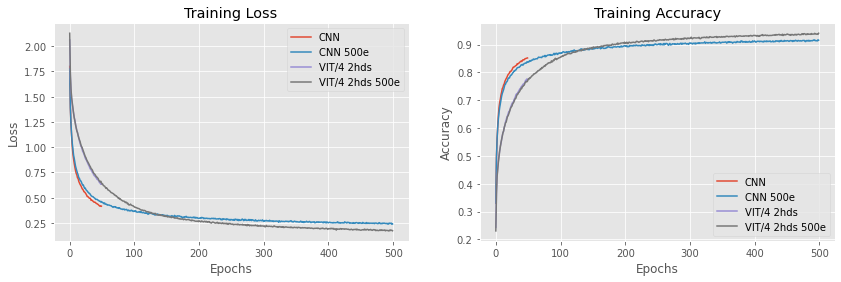

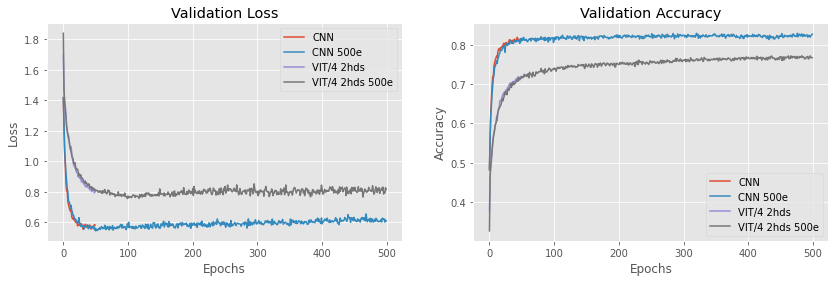

In [32]:
legends = ['CNN', 'CNN 500e', 'VIT/4 2hds', 'VIT/4 2hds 500e']
histories = [history_cnn, history_cnn_500epoch, 
             history_vit_4x4_2hd, history_vit_4x4_2hd_500epoch]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])

In [33]:
%%script false
# This is just for reference.

# batch_size = 256
# epochs = 1
# model = VIT(num_classes=num_classes, 
#             image_height=image_height, 
#             image_width=image_width,
#             patch_size=4, 
#             projection_dim=32,
#             num_layers=4,
#             num_heads=2,
#             mlp_dims=[64, 32],
#             classifier_mlp_dims=[512],
#             preprocess=False).model()
# train_and_eval(model, 'DUMMY_VIT')
# model.evaluate(data_generator('val', batch_size))
# model_VIT = tf.keras.models.load_model('DUMMY_VIT')
# Somehow the load model does not always load the variables.
# model_VIT.load_weights('DUMMY_VIT/variables/variables')
# model_VIT.evaluate(data_generator('val', batch_size))